<a href="https://colab.research.google.com/github/ImagingDataCommons/IDC-Examples/blob/master/notebooks/lung_nodules_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

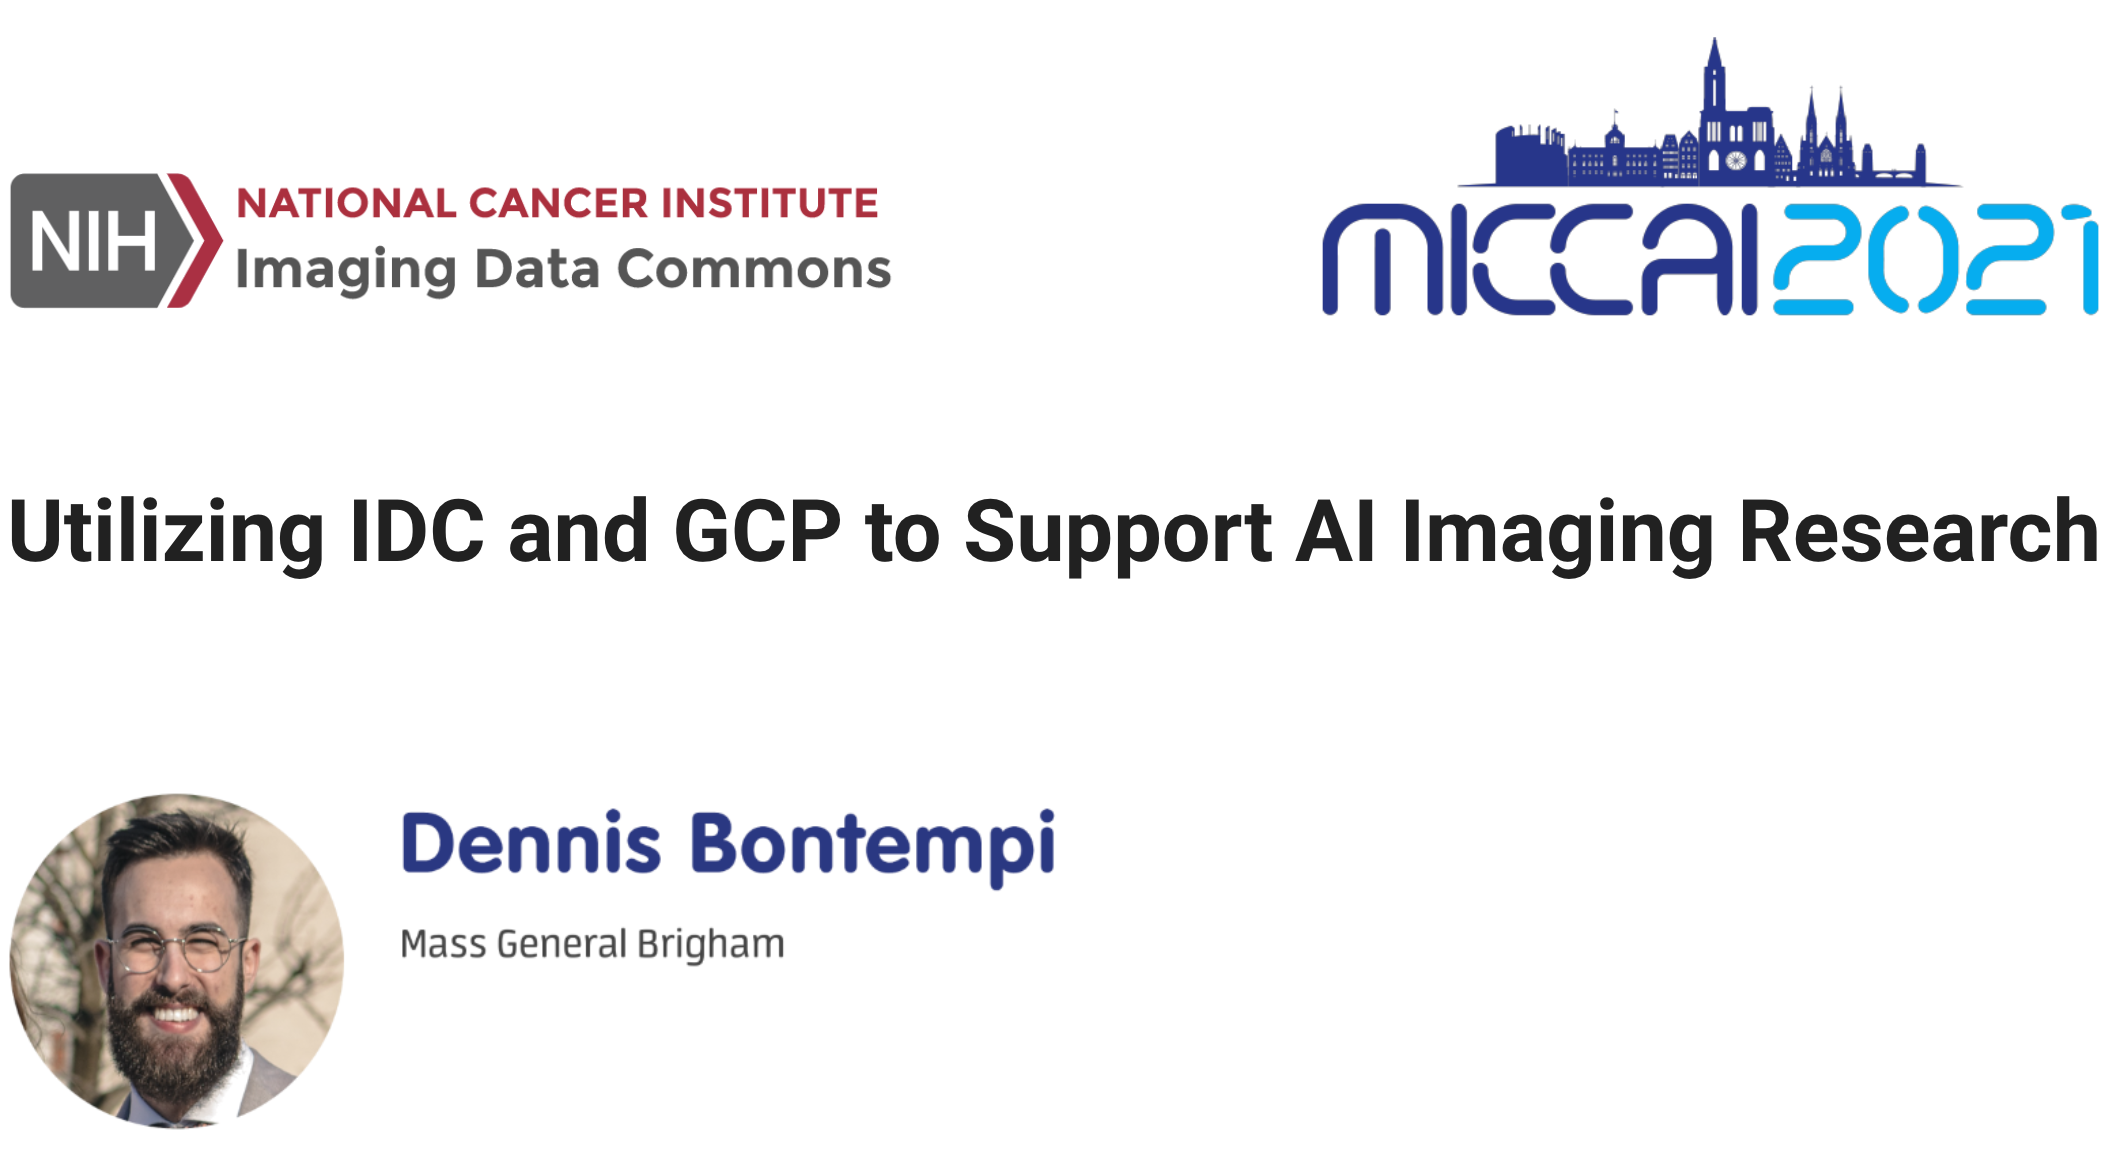

17:15 - 17:30 (UTC)

https://data4miccai.github.io

---

The purpose of this brief tutorial session is to showcase how the IDC platform integrates with the Google compute engines, and discuss what role can IDC play in AI imaging research in the upcoming years.

# **If you are an AI researcher, why should you consider using IDC?**

- **IDC promotes transparency.**

- **IDC simplifies the data exploration and selection process.**

- **IDC promotes reproducibility and facilitates the discovery of new use cases for your model.**

- **IDC promotes best practices in the field.**

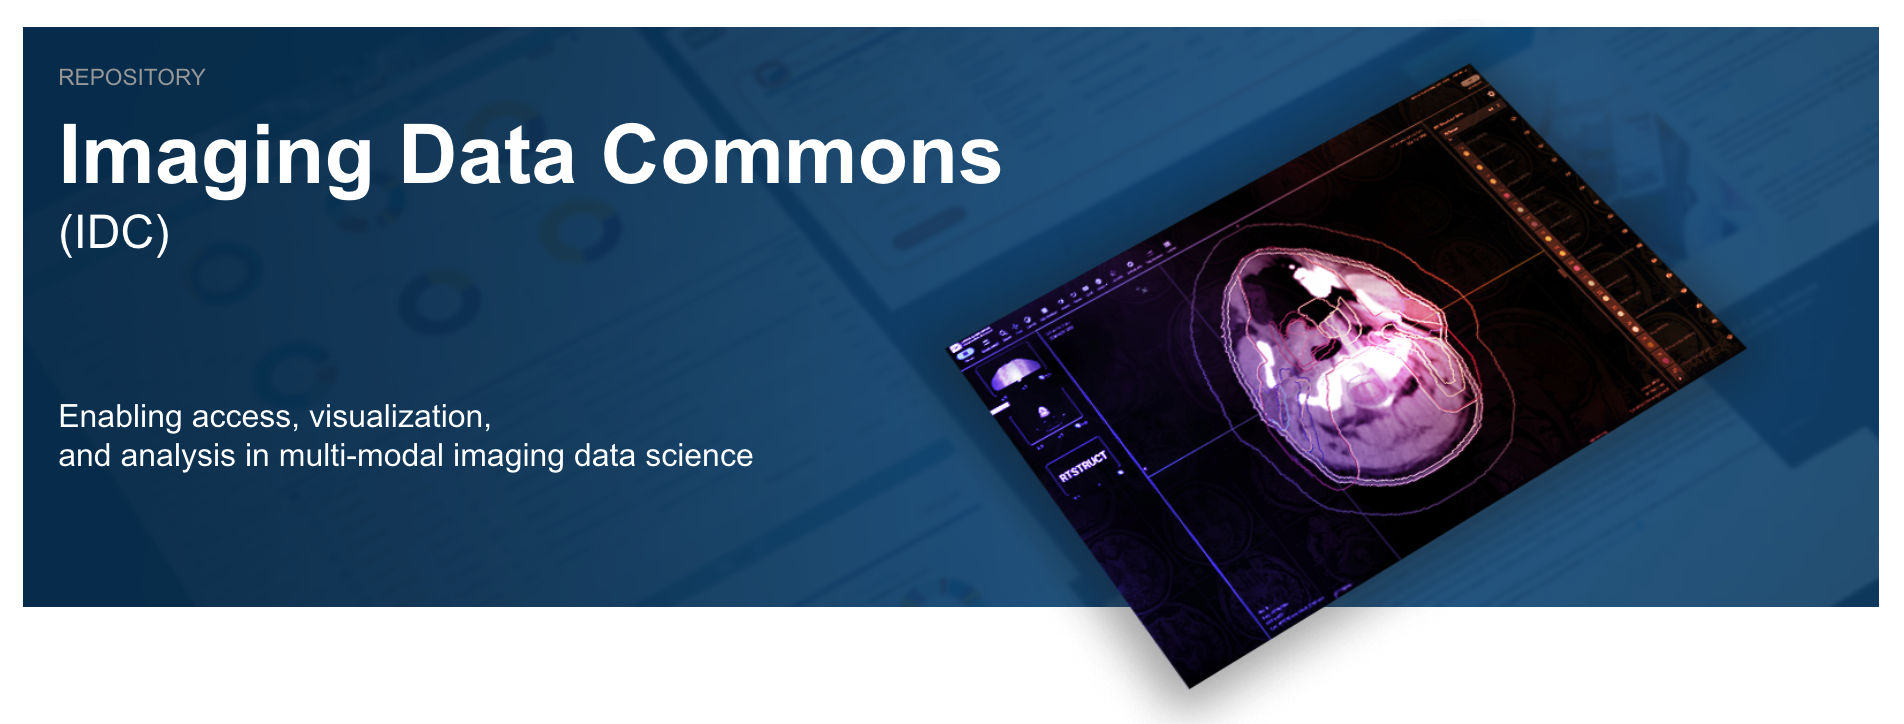



---

# **Introduction to the Tutorial**

In this tutorial, we will address: 

* How to select, access, and download cohorts from IDC;
* What are some of the tools that can be used to get the DICOM data ready for your favourite imaging analysis pipelines;
* How to run an end-to-end pipeline and visualise the final results exploiting the Google Cloud Computing (GCP) and IDC platform.

<br>

**To access the resources needed for this tutorial, you will need to be registered on the IDC platform and set up a GCP project.**

First, if you are not yet registered to IDC, [sign up at this link](https://portal.imaging.datacommons.cancer.gov/accounts/signup/) or simply make sure you can [sign in at the IDC portal via your Google account](https://portal.imaging.datacommons.cancer.gov/accounts/login/)

Second, creating a Google Cloud Computing project is easy and free. You should be able to do it at [this link](https://console.cloud.google.com/projectselector2/home/dashboard) in just a few clicks:
* Once the page opens up, click on the "Create Project" button on the right;
* Give the project a name (e.g., "my-first-project"), and select your organisation (or simply no organisation at all). 

You can read more about the creation and managing of GCP project at the [dedicated documentation page](https://cloud.google.com/appengine/docs/standard/nodejs/building-app/creating-project)




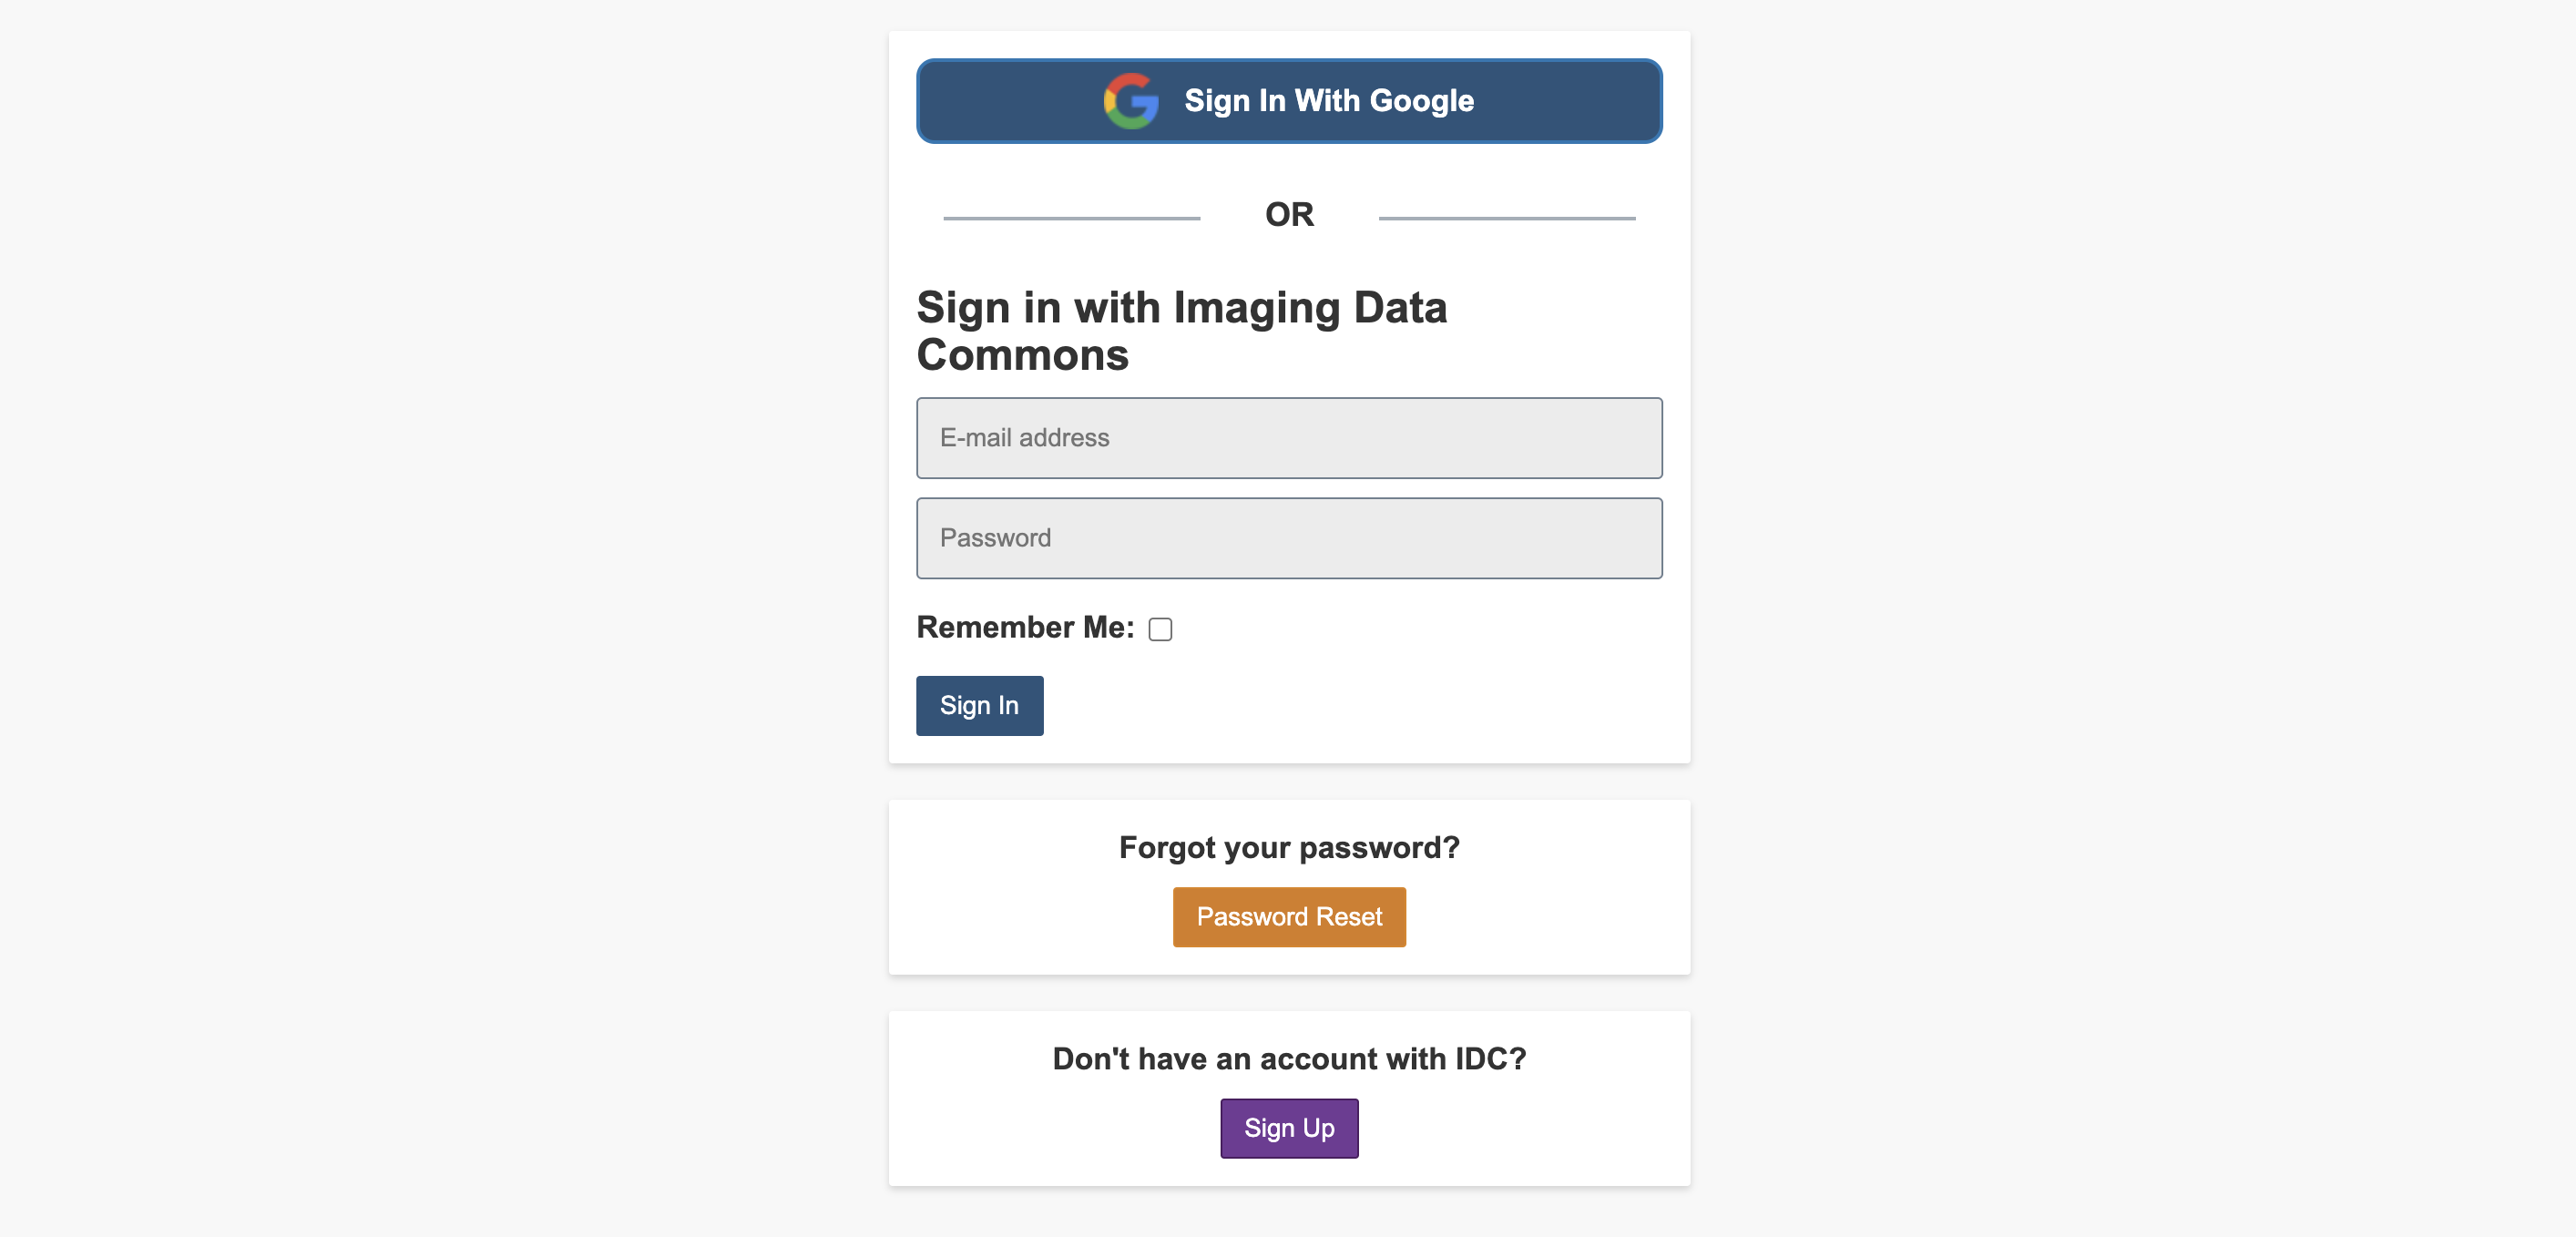

<br>

**To speed up the AI Image Processing pipelines, make sure the Colab Instance you are using is equipped with a GPU.**

You can check by clicking on "Runtime" in the menu bar, then selecting "Change Runtime Type" and making sure "GPU" is selected as Hardware acceleration. Colab GPUs include Nvidia K80s, T4s, P4s and P100s. As there is no way to choose what type of GPU you can connect to in Colab at any given time, processing times may vary.

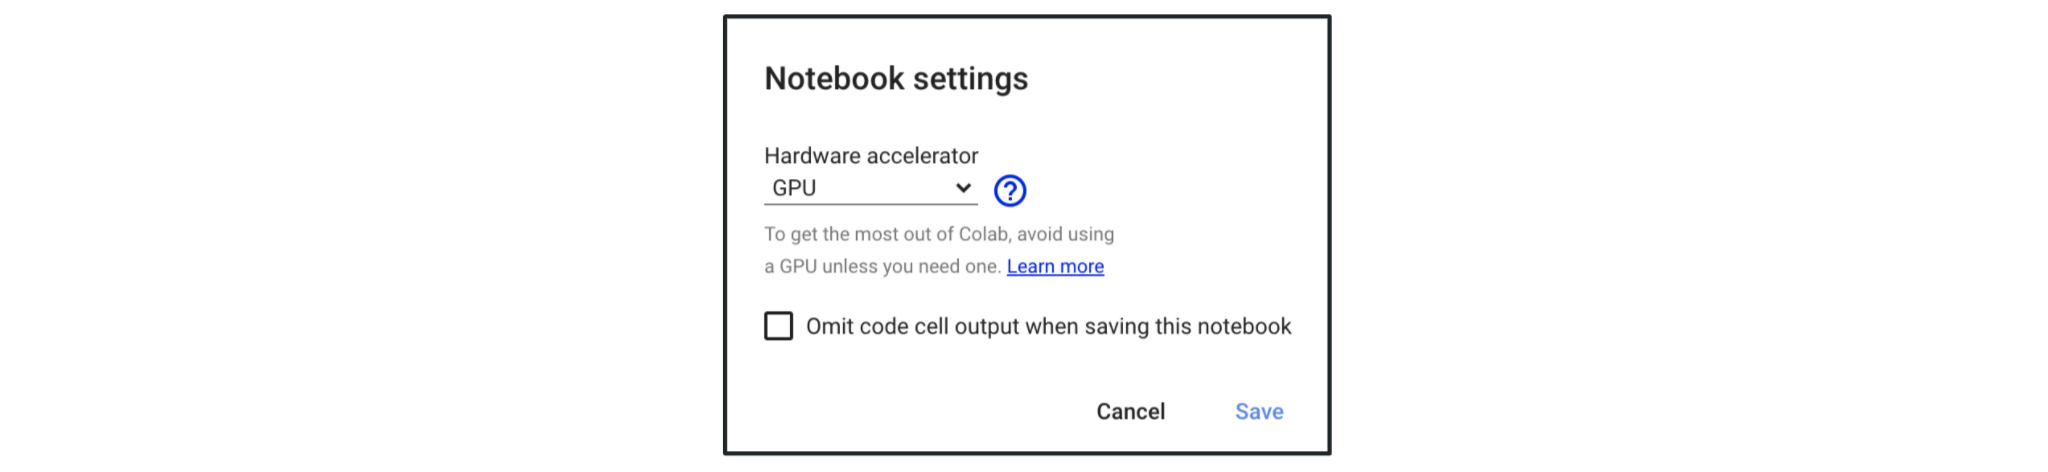

---

<br>

**In this notebook, we will test and end-to-end AI pipeline for lung nodule prognosis from CT scans on patients from the Non-Small Cell Lung Cancer Radiomics (NSCLC-Radiomics) dataset.**

The AI pipeline is divided in two main steps. First, to automatically segment any lung nodule found in a chest CT scan, we will use one of the pre-trained models shared as part of the [nn-Unet model collection](https://www.nature.com/articles/s41592-020-01008-z). Second, to conduct the automatic lung nodule analysis we will use [DeepPrognosis](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002711), a Convolutional Neural Network trained to estimate a 2-year survival score starting from the segmentation mask of the nodule.

<br>

**The AI models deployed in this notebook have been trained on external and completely independent datasets from the IDC cohorts we are about to test them on.**

The idea behind this tutorial is therefore not to showcase a perfect AI-based processing pipeline, but rather investigate how IDC can help promoting transparency, reusability and reproducibility in AI - potentially accelerating the translation of these methods into clinical settings.


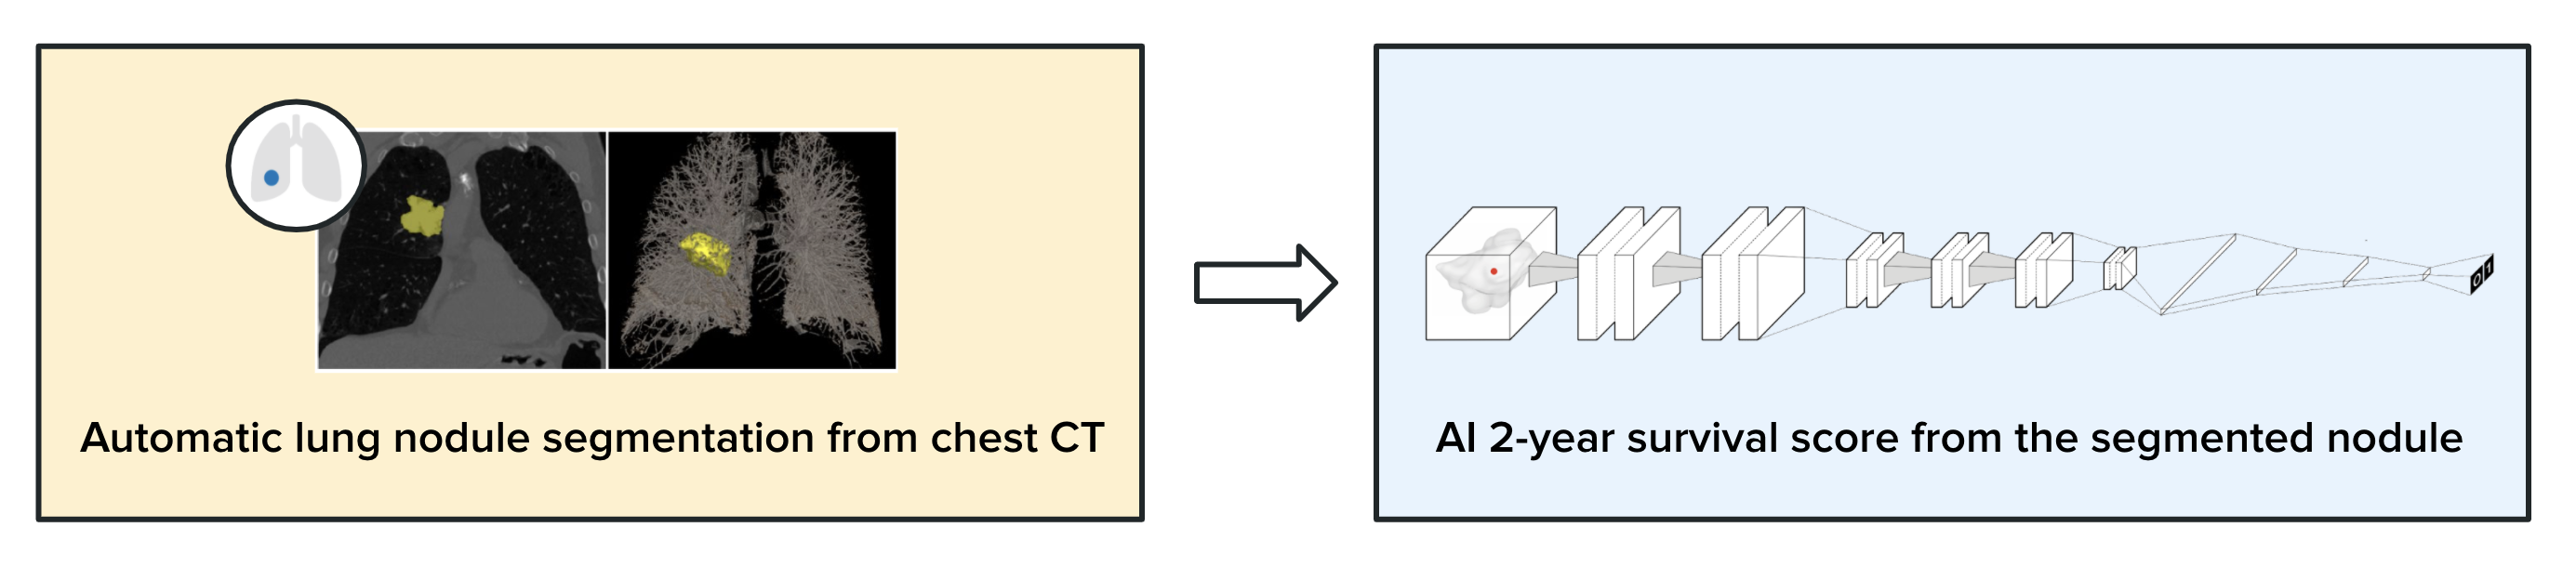

---

<br>

Since this demonstration runs in Google Colab, it highlights only a small part of what IDC can offer in terms of computational capability and imaging analysis: a more comprehensive experience of such tools can be explored, e.g., by experimenting with GCP Virtual Machines.

To learn more about how to access the GCP virtual machines for free (exploiting GCP and/or IDC [free cloud credits](https://learn.canceridc.dev/introduction/requesting-gcp-cloud-credits)) and about the IDC platform, please visit the [IDC user guide](https://learn.canceridc.dev/).

<br>

**Any questions, bugs to report, or features you would like to see implemented in IDC?**

You are welcome to get in touch with us at the [IDC discussion forum](https://discourse.canceridc.dev/)!


---

# **Init & Imports**

In order to access the IDC resources, the user must complete at first the Google authentication process.

To continue with the notebook, when prompted by the next code cell follow the generated link. After granting Google Cloud SDK access to the selected Google account, you will get a one-use login code. Copy the code, paste it in the blank space under the cell, and press enter to complete the authentication procedure.

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
# useful information
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("Current directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

Current directory : /content
Hostname          : a5a621b08cca
Username          : root


Before continuing with the notebook, we need to set-up the Google Colab environment by installing the Python and system dependencies the pre-processing and processing pipeline rely on.

## **Python Dependencies**

Install and import all the Python dependencies. 

The main python packages we need to install are:
* `nnunet` - which is the [codebase for the nn-UNet framework](https://github.com/MIC-DKFZ/nnUNet) we are going to be using for the segmentation step;
* `pydicom`, a Python [package](https://github.com/pydicom/pydicom) that lets the use read, modify, and write DICOM data in an easy "pythonic" way - that we are going to use to distinguish different DICOM objects from each other.

In [3]:
%%capture
!pip install nnunet
!pip install pydicom

In [4]:
# check wether the Colab Instance was correctly changed to a GPU instance
gpu_list = !nvidia-smi --list-gpus

has_gpu = False if "failed" in gpu_list[0] else True

In [5]:
import os
import sys
import shutil

import time
import gdown

import json
import pprint
import numpy as np
import pandas as pd

import pydicom
import nibabel as nib
import SimpleITK as sitk

from medpy.metric.binary import dc as dice_coef
from medpy.metric.binary import hd as hausdorff_distance
from medpy.metric.binary import asd as avg_surf_distance

from medpy.filter.binary import largest_connected_component

# use the "tensorflow_version" magic to make sure TF 1.x is imported
%tensorflow_version 1.x
import tensorflow as tf
import keras

print("Python version               : ", sys.version.split('\n')[0])
print("Numpy version                : ", np.__version__)
print("TensorFlow version           : ", tf.__version__)
print("Keras (stand-alone) version  : ", keras.__version__)

print("\nThis Colab instance is equipped with a GPU.")

# ----------------------------------------

#everything that has to do with plotting goes here below
import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## ----------------------------------------

# create new colormap appending the alpha channel to the selected one
# (so that we don't get a \"color overlay\" when plotting the segmask superimposed to the CT)
cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

## ----------------------------------------

import seaborn as sns

TensorFlow 1.x selected.
Python version               :  3.7.12 (default, Sep 10 2021, 00:21:48) 
Numpy version                :  1.19.5
TensorFlow version           :  1.15.2
Keras (stand-alone) version  :  2.3.1

This Colab instance is equipped with a GPU.


Using TensorFlow backend.


In [6]:
# check which model of GPU the notebook is equipped with - a Tesla K80 or T4
# T4 is the best performing on the two - and can about half the GPU processing time

!nvidia-smi

Mon Sep 27 11:47:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **System Dependencies**

Install all the system dependencies. 

The only package we will need for this tutorial is [Plastimatch](https://plastimatch.org/index.html). Plastimatch is considered to be the swiss army knife of medical images processing: we will use it to convert DICOM (CT, RTSTRUCT) series to NRRD files - but it can be used for a multitude of other tasks, such as registration, resampling, cropping, and computing statistics to name a few. Plastimatch is also available as a 3DSlicer plug-in and can be used directly from the Slicer GUI.

For the sake of clarity and simplicity, we will call Plastimatch from a very simple [Python wrapper](https://github.com/denbonte/pyplastimatch) written for the occasion (unfortunately, Plastimatch does not provide an official one) - more on this later.

In [7]:
%%capture
!sudo apt update

!sudo apt install plastimatch

In [8]:
!echo $(plastimatch --version)

plastimatch version 1.7.0


We are also going to install subversion, a tool that will allow us to clone GitHub repositories only partially (to save time and space).

In [9]:
%%capture

!sudo apt install subversion

In [10]:
!echo $(svn --version | head -n 2)

svn, version 1.9.7 (r1800392) compiled Mar 28 2018, 08:49:13 on x86_64-pc-linux-gnu


## **Environment Setup**

Set the Linux environment variables needed to run the nnU-Net pipeline. 

Three main variables are needed by default to run the nnU-Net segmentation pipelines:
* `nnUNet_raw_data_base` is the path to the folder where the segmentation pipeline expects to find the data to process;
* `nnUNet_preprocessed` is the path to the folder where the preprocessed data are saved;
* `RESULTS_FOLDER` is the path to the folder storing by default the model weights and, in our case, for simplicity, the segmentation masks produced by the pipeline.

We will use the additional variable `PATH_TO_MODEL_FILE` to point to the location where the pre-trained model weights for the chosen model will be stored (more on this later).

Please notice that these variables need to be set using `os.environ[]` in Google Colab - as `!export` is not sufficient to guarantee the variables are kept from one cell to the other. For more in-depth information regarding what the nnU-Net framework uses these folders for, please visit [the dedicated nnU-Net documentation page](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/setting_up_paths.md)

In [11]:
# set env variables for the bash process
os.environ['nnUNet_raw_data_base'] = "/content/tutorial/data/nnUNet_raw_data/"
os.environ['nnUNet_preprocessed'] = "/content/tutorial/data/processed/"

os.environ["RESULTS_FOLDER"] = "/content/tutorial/output/"
os.environ["PATH_TO_MODEL_FILE"] = "/content/tutorial/models/Task006_Lung.zip"

---

# **Models Download**

Download all the files needed to load the two pre-trained models.


## **Lung Nodules Segmentation Model**

While the nnU-Net framework should take care of the model download (from Zenodo), some of the zip files containing the pre-trained weights are particularly large, so the download can take a lot of time, get stuck, or produce errors (as [reported by other users](https://github.com/MIC-DKFZ/nnUNet/issues/358#issue-726410474) and in the [repository FAQ](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/common_problems_and_solutions.md#downloading-pretrained-models-unzip-cannot-find-zipfile-directory-in-one-of-homeisenseennunetdownload_16031094034174126)) .

For this reason, and for the purpose of speeding up this tutorial, we decided to copy the relevant model weights in a shared Dropbox folder. In the following cells, we use Linux `wget` to pull such files from the folder - and exploit the nnU-Net framework command `nnUNet_install_pretrained_model_from_zip` to unpack and install the pre-trained model.

In [12]:
# create the directory tree
!mkdir -p tutorial 
!mkdir -p tutorial/models tutorial/data tutorial/output
!mkdir -p tutorial/data/tmp tutorial/data/dicom tutorial/data/processed tutorial/data/nnUNet_raw_data

In [13]:
# this will usually take between one and five minutes
seg_model_url = "https://www.dropbox.com/s/4ajcm2rvd8z40f1/Task006_Lung.zip?dl=0"
output_path = "tutorial/models/Task006_Lung.zip"

!wget -O $output_path $seg_model_url

--2021-09-27 11:47:58--  https://www.dropbox.com/s/4ajcm2rvd8z40f1/Task006_Lung.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4ajcm2rvd8z40f1/Task006_Lung.zip [following]
--2021-09-27 11:47:58--  https://www.dropbox.com/s/raw/4ajcm2rvd8z40f1/Task006_Lung.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce458612613a76fcb82c71a8420.dl.dropboxusercontent.com/cd/0/inline/BW9Qj47UKlNAm2c0CdVXGR7fwcxQoHhCaZtPQO8cCkjKjuGdLjb1MR9VKqVbkI7Svc_aFXRl2_s6l7kHu7fE4DmpH5gy_8rH5KDjayV7pOPDRy9co4rKFVc_PecvatwzW1qib_z4Txc2itM3fKKBvtHE/file# [following]
--2021-09-27 11:47:59--  https://uce458612613a76fcb82c71a8420.dl.dropboxusercontent.com/cd/0/inline/BW9Qj47UKlNAm2c0CdVXGR7fwcxQoHhCaZtPQO8cCkjKjuGdLjb1MR9VKqVbkI7Svc_aFX

Unpack and install model (under `PATH_TO_MODEL_FILE`).

In [14]:
%%capture
!nnUNet_install_pretrained_model_from_zip $PATH_TO_MODEL_FILE

## **Lung Nodules Prognosis Model**

Download the DeepPrognosis pre-trained model weights and architecture file from the shared Dropbox folder.

In [15]:
prognosis_model_weights_url = "https://www.dropbox.com/s/brhu1j9dq0d5rry/weights.h5?dl=0"
output_path = "tutorial/models/dp_weights.h5"

!wget -O $output_path $prognosis_model_weights_url

# ----------------------------------------

prognosis_model_arch_url = "https://www.dropbox.com/s/f7flnqltxvyxg3b/architecture.json?dl=0"
output_path = "tutorial/models/dp_arch.json"

!wget -O $output_path $prognosis_model_arch_url

--2021-09-27 11:54:10--  https://www.dropbox.com/s/brhu1j9dq0d5rry/weights.h5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/brhu1j9dq0d5rry/weights.h5 [following]
--2021-09-27 11:54:10--  https://www.dropbox.com/s/raw/brhu1j9dq0d5rry/weights.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf1400d0a037659a746a7452325.dl.dropboxusercontent.com/cd/0/inline/BW_ZVSOQ5XhiyWL6RlUoXJEr-jReS9onV7ozPy500Pm79A9mj9ZuCEUaXlkOApwLEDA5fsEXf0nOu6PbrQOIwWGoVUW9zwONaDL4sQVfDUCHcYnOGVlMyZHXRNoDGPn9FJCH1D7nJmU-VqH75Yw2UHKk/file# [following]
--2021-09-27 11:54:11--  https://ucf1400d0a037659a746a7452325.dl.dropboxusercontent.com/cd/0/inline/BW_ZVSOQ5XhiyWL6RlUoXJEr-jReS9onV7ozPy500Pm79A9mj9ZuCEUaXlkOApwLEDA5fsEXf0nOu6PbrQOIwWGoV

---

# **Cohort Download**

In this tutorial, we will test the end-to-end AI pipeline for lung nodule prognosis from CT scans on patients from the Non-Small Cell Lung Cancer Radiomics (NSCLC-Radiomics) dataset.

The NSCLC-Radiomics cohort contains images from stage I–IIIb NSCLC patients imaged with CT, with or without intravenous contrast, and treated with radiation therapy at MAASTRO Clinic, Maastricht, The Netherlands. Images were acquired between 2004 and 2010. For these patients pretreatment CT scans, manual delineation by a radiation oncologist of the 3D volume of the gross tumor volume and clinical outcome data are available. This dataset is referred to as "LUNG1" in [Aerts et Al. - Decoding tumour phenotype by noninvasive imaging using a quantitative radiomics approach](https://www.nature.com/articles/ncomms5006), (Nature Communications, 2014).

## **Cohort(s) Selection on IDC**

As the Imaging Data Commons GCS buckets are "[requester pays](https://cloud.google.com/storage/docs/requester-pays)" buckets, it is not possible to [mount such buckets directly in Colab](https://gist.github.com/korakot/f3600576720206363c734eca5f302e38).

Instead, what the users can do is to query the BigQuery table associated with the dataset(s), select the cohort(s) of interest, and then download the files exploiting `gsutil`. Such cohort selection operation can be done through the graphic user interface at the [IDC Portal](https://portal.imaging.datacommons.cancer.gov/): here follows a graphical summary of how to do so.

### **Step 1 - Site/Collection Selection**

IDC can be used to build an analysis cohort in multiple ways.

For instance, on the [main page of the portal](https://portal.imaging.datacommons.cancer.gov/), the user can click on a site icon to browse all the data related to the anatomical site of interest. Another way to build a cohort is to use the "Exploration" functionality of IDC to then manually define search filters. Last but not least, we can directly browse the different collections hosted by IDC. To learn more about these tools and further explore the topic, you can visit the [Exploring Data and Cohorts page of the IDC documentation](https://learn.canceridc.dev/portal/data-exploration-and-cohorts). 

For the purpose of this notebook, we are interested in patients with chest CT findings - especially, patients with lung nodules - and the correspondent manual delineations. As previously mentioned, the NSCLC-Radiomics dataset is one of the collections for which this data is available, so let us search the dataset under "Collections".

idc_collections.png

At the ["Collections" page](https://portal.imaging.datacommons.cancer.gov/collections/), all the different collections available in IDC are listed and sorted alphabetically. Basic yet usefult information are reported together with the collection name:

- the type of collection, either "Original" (for data provided before any processing) or "Analysis" (for data resulting from a processing/analysis pipeline, usually associated with one or more IDC collections);
- the cancer type for which imaging information have been collected;
- the type of modalities provided (from MR and CT with or without RT data, to digital pathology data);
- the number of distinct subjects for which such imaging data is available;
- the anatomical site covered by the imaging data;
- the support data available for the dataset (e.g., clinical data, genomics data). 

<br>

We can use the search button on the top right or scroll down until we find "NSCLC-Radiomics".

By clicking on the small plus button on the left we can visualize additional information on the dataset: its DOI, a rough description of the data it contains, and a link to its documentation page. To move forward with the data selection, the user can click on the dataset name.

nsclc_collection.png

### **Step 2 - Data Browsing and Filtering**

Once the NSCLC-Radiomics collection has been chosen, we can apply different filters to select the right type of data for our pipeline.

The segmentation model we are about to deploy was trained to segment nodules from non-contrast chest CT images: therefore, we can go on and select "Lung" as the "Body Part Examined" on the pie on the right, and then "Computed Tomography" on the "Modality" pie at the center.

nsclc_ct_filter.png

We can then click on the "Derived" tile to browse the segmentation data available.

For the purpose of this notebook, we are interested in patients for which manual delineation of lung nodules on chest CT are available. Therefore, we are going to select "Neoplasm; Primary (SCT)" from the "Segmentation Type" pie on the right.

nsclc_neoplasm_filter.png

### **Step 3 - Saving a New Cohort and Exporting It**

After logging in, (e.g., sign In with your Google Account) you will be able to save the selected cohort by clicking on "Save as New Cohort".

save_cohort.png


Every cohort is associated with a version of the data release: if in the future the selected dataset(s) change, the user will still be able to link the analysis results to the precise version of the data they were computed on, and therefore reproduce the results of such analysis.

To learn more about IDC versioning, you can visit [the Data Versioning page at of the IDC documentation](https://learn.canceridc.dev/data/data-versioning).

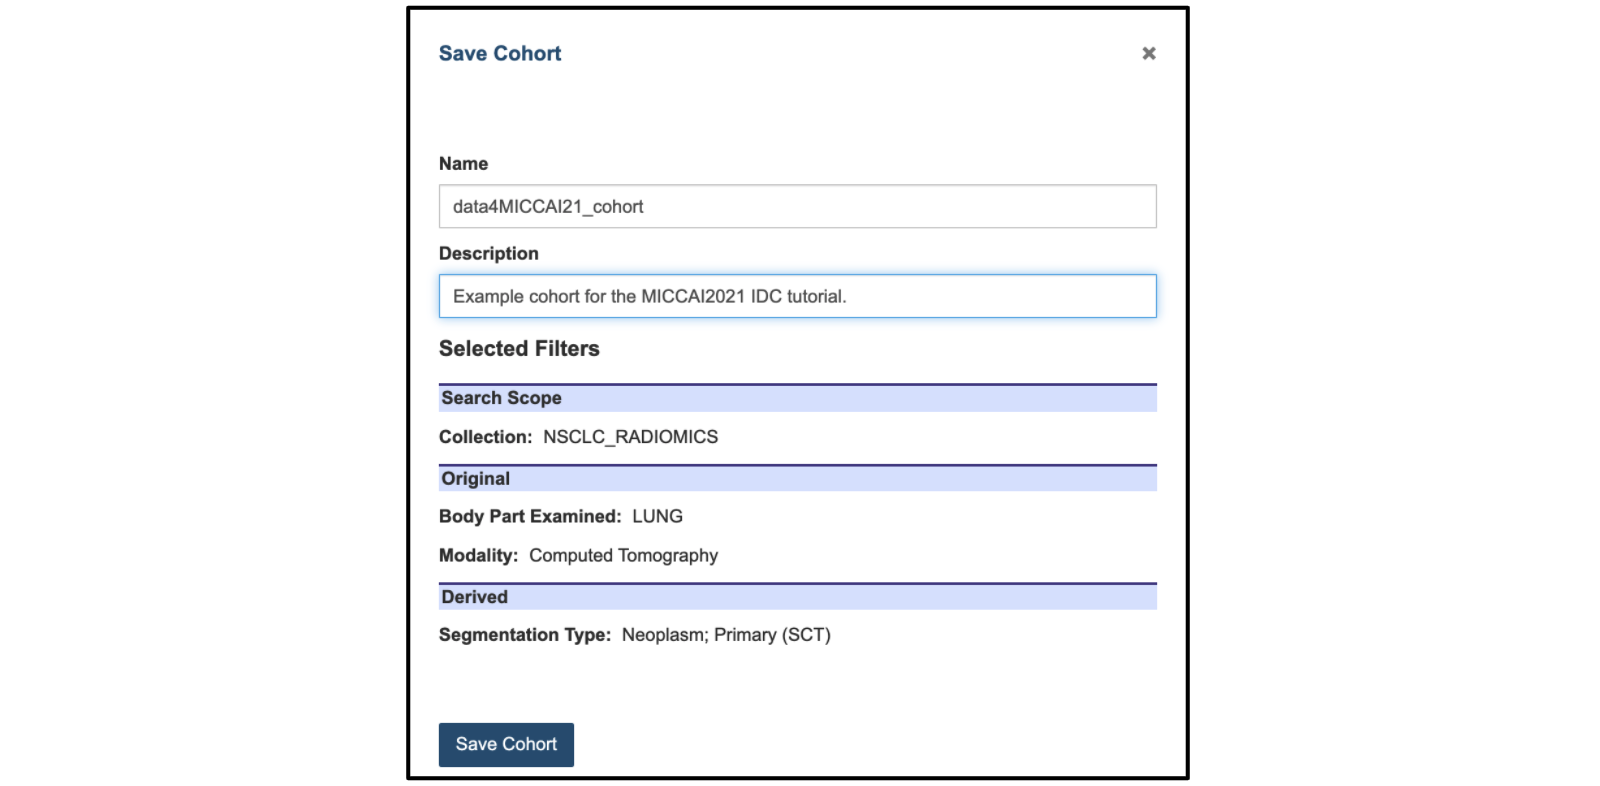

To export the cohort data we need for the download, after choosing a name and a description, you will be able to click the same purple button which will have now become "Export Cohort Manifest".

Screenshot 2021-08-24 at 11.13.15.png


**Note**: in general, the data can be downloaded from IDC either using directly the manifest (the "not recommended" approach - generate GCS URIs from the manifest itself) or exploiting BigQuery queries. See this [cohort download notebook](https://github.com/ImagingDataCommons/IDC-Examples/blob/master/notebooks/Cohort_download.ipynb) to learn more about the process.

In this Notebook, we will exploit BigQuery tables to fetch the data from the IDC buckets (the "recommended" approach).

<br>

After clicking the "Export Cohort Manifest" button, when prompted, select "BigQuery" in the dialog box.

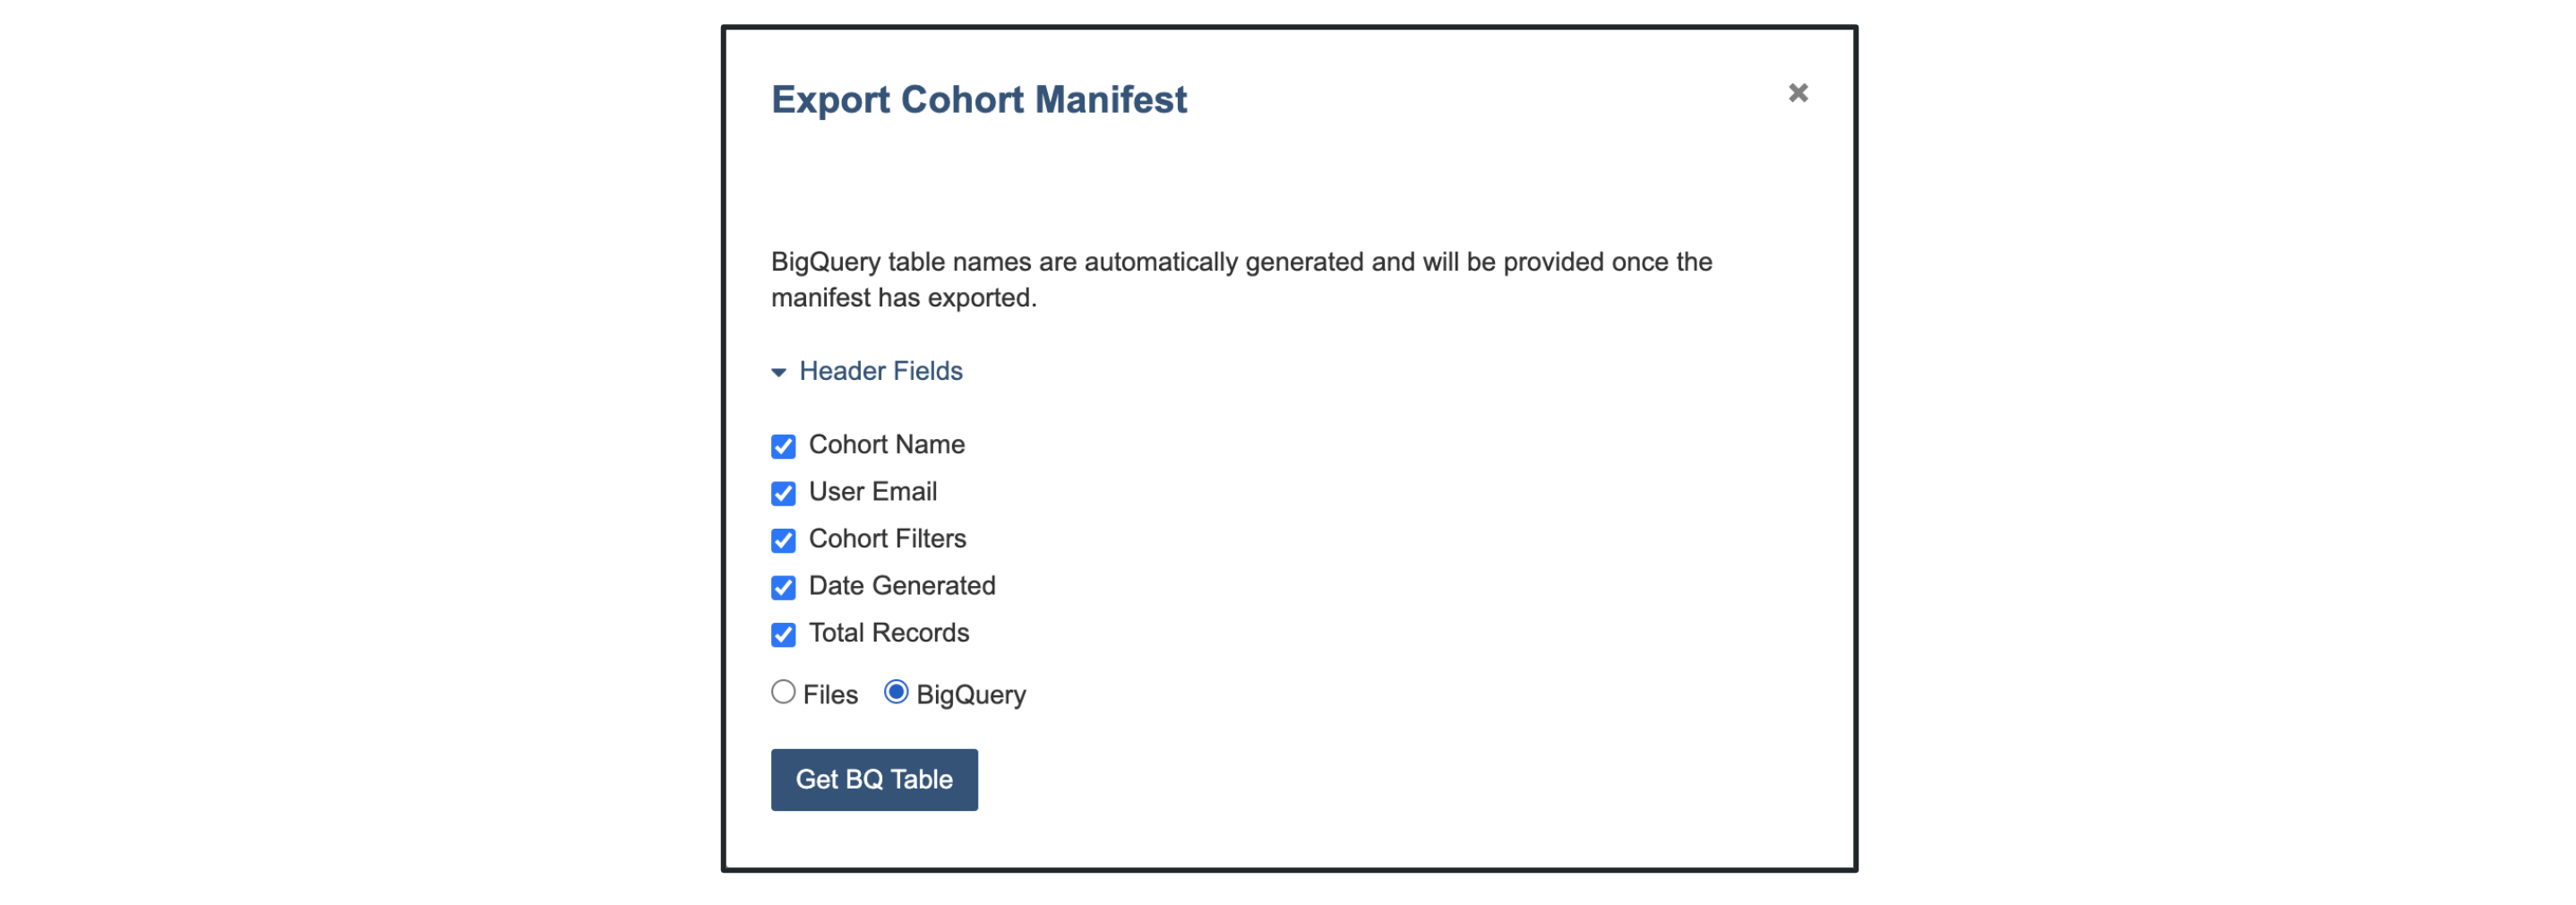

The portal will now generate the correspondend BigQuery query: once that is done, follow the link to the Google Cloud Computing platform and click on "Query" in the cohort manifest panel. You can copy the content of the query in the next code cell, remove the `LIMIT 1000` at the end, and procede with the next part of the notebook. 

query.png

## **Downloading the Data from GCS**

In the next cell, make sure to fill in the name of your GCP project and paste the query we obtained following the cells above.

At the end, it should look like the following:

```
%%bigquery --project=my-gcp-project cohort_df

SELECT * FROM `canceridc-user-data.user_manifests.manifest_cohort_222_20210811_071925`
```

In [16]:
# magic   | name of the variable to save the table to |         project name      | 
%%bigquery cohort_df --project=$GCP_PROJECT_NAME_HERE 

SELECT * FROM `$BIGQUERY_TABLE_NAME_HERE`

After populating the Pandas DataFrame with the result of the bigquery query, we can inspect it to make sure it looks ok.

As you will see, each DICOM slice has its own entry (that's why one has to remove `LIMIT 1000` from the query to get the complete result) and a series of useful information:
* on the dataset it belongs to - especially useful in the case multiple datasets are exported as part of an IDC cohort - such as the `collection_id` and the `source_DOI`;
* on the patient, study, and series it belongs to, such as the `PatientID`, `StudyInstanceUID` and `SeriesInstanceUID`;
* on the GCS bucket location and organisation, such as `gcs_url`, `crdc_instance_uuid`, and `crdc_series_uuid`.



In [18]:
cohort_df.head()

PatientID  ...                                            gcs_url
0  LUNG1-312  ...  gs://idc-open/92d8d7fd-31e8-4570-be42-7c005c0d...
1  LUNG1-079  ...  gs://idc-open/c141a2ff-7e32-41d3-b8fe-ddfd4e62...
2  LUNG1-044  ...  gs://idc-open/5d388d3d-38f0-46e9-aaec-6a8a1070...
3  LUNG1-094  ...  gs://idc-open/8c9e6457-0217-45b9-9cbc-b680e353...
4  LUNG1-018  ...  gs://idc-open/8dd0f9f7-b1b9-4ce1-a615-149c67c0...

[5 rows x 10 columns]

We can now select a patient from the dataframe, get all the `gcs_url` entries, and download the DICOM data associated with it (DICOM CT, DICOM RTSTRUCT and DICOM SEG, in this case).

For the purpose of this tutorial (and all the steps that follow), we are going to select the patient `LUNG1-007` (which we know has a lung nodule of discrete size that we will be able to visualise, and the segmentation model segments sufficiently well). Once again, the AI models we are deploying were trained and validated on external and independent datasets: in this notebook, we are not interested in a thorough technical validation of such pipelines - rather, we want to investigate how well they generalize in the most transparent and reproducible way possible.

<br>

**Note** - in order for the download from GCS to take place, the user needs to specify the GC project name again after `-u` option in the `gsutil` command. You can learn more about all the useful options `gsutil` provides the user with at the [dedicated documentation page](https://cloud.google.com/storage/docs/gsutil).

In [19]:
gs_file_path = "tutorial/data/gcs_paths.txt"

# specify an arbitrary PatientID
pat = "LUNG1-007"
sliced_df = cohort_df[cohort_df["PatientID"] == pat]

sliced_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

In [20]:
%%capture
# https://cloud.google.com/storage/docs/gsutil/commands/cp
!mkdir -p tutorial/data/tmp
!cat $gs_file_path | gsutil -u $GCP_PROJECT_NAME_HERE -m cp -Ir tutorial/data/tmp

As you will notice, for instance, by browsing the `tutorial/data/tmp` folder, the DICOM files will not be organised by default following patients, series, or studies.

To organise the data in a more common (and human-understandable) fashion, we will make use of [DICOMSort](https://github.com/pieper/dicomsort). DICOMSort is an open source tool for custom sorting and renaming of dicom files based on their specific DICOM tags. In our case, we will exploit DICOMSort to organise the DICOM data by `PatientID`, `StudyInstanceUID`, and `SeriesInstanceUID` - so that the final directory will look like the following:

```
tutorial/data/dicom/$PatientID
 └─── $StudyInstanceUID
       ├─── $SeriesInstanceUID_CT
       │     ├─── $SOPInstanceUID_slice0.dcm
       │     ├─── $SOPInstanceUID_slice1.dcm
       │     ├───  ...
       │
       ├─── $SeriesInstanceUID_RTSTRUCT
       │     └─── $SOPInstanceUID_RTSTRUCT.dcm
       │
       └─── $SeriesInstanceUID_RTSEG
             └─── $SOPInstanceUID_RTSEG.dcm

```

Furthermore, to prepare the data for processing (e.g., data conversion from DICOM) we will make use of [PyPlastimatch](https://github.com/denbonte/pyplastimatch/), a very basic python wrapper for Plastimatch, written for the purpose of this tutorial. The wrapper also contains a very basic yet interactive visualisation function we will be using in the last part of the notebook to check the segmentation results.

In [21]:
# DICOMSORT - for re-organising DICOM files in folders
!git clone https://github.com/pieper/dicomsort.git tutorial/dicomsort

# PyPlastimatch - python wrapper for Plastimatch (and interactive notebook visualisation)
!svn checkout https://github.com/denbonte/pyplastimatch/trunk/pyplastimatch tutorial/pyplastimatch

Cloning into 'tutorial/dicomsort'...
remote: Enumerating objects: 126, done.
remote: Total 126 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (126/126), 37.03 KiB | 4.63 MiB/s, done.
Resolving deltas: 100% (63/63), done.
A    tutorial/pyplastimatch/pyplastimatch.py
A    tutorial/pyplastimatch/utils
A    tutorial/pyplastimatch/utils/data.py
A    tutorial/pyplastimatch/utils/viz.py
Checked out revision 9.


In [22]:
# run the DICOMSort command
!python tutorial/dicomsort/dicomsort.py -u tutorial/data/tmp tutorial/data/dicom/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm

# get rid of the temporary folder, storing the unsorted DICOM data 
!rm -r tutorial/data/tmp

100% 131/131 [00:01<00:00, 94.65it/s]
Files sorted


---

# **Data Pre-processing**

In order to run the AI segmentation and prognosis pipelines, we need to convert the DICOM data in a format which python can easily handle

Using the simple Plastimatch wrapper, let's convert the DICOM CT series in both NRRD (very flexible, simple handling with SimpleITK) and NIfTI (as required by the nnU-Net pipeline) format. Furthermore, we are going to convert the DICOM RTSTRUCT Series into a NRRD volume as well - to allow for comparison between the manual and automatic segmentation, later in the notebook.


In [23]:
from tutorial.pyplastimatch import pyplastimatch as pypla
from tutorial.pyplastimatch.utils import viz as viz_utils
from tutorial.pyplastimatch.utils import data as data_utils

Let's start by identifying the unique `SeriesInstanceUID` in our small dataset: 

In [24]:
StudyInstanceUID = sliced_df["StudyInstanceUID"].values[0]
SeriesInstanceUID_list = sliced_df["SeriesInstanceUID"].values

SeriesInstanceUID_unique = list(np.unique(SeriesInstanceUID_list))

for SeriesInstanceUID in SeriesInstanceUID_unique:
  if len([x for x in SeriesInstanceUID_list if x == SeriesInstanceUID]) > 1:
    SeriesInstanceUID_ct = SeriesInstanceUID

SeriesInstanceUID_unique.remove(SeriesInstanceUID_ct)

Then, let's check the `Modality` tag of the DICOM Series to separate the CT Series from the RTSTRUCT and SEG ones.

In [25]:
for SeriesInstanceUID in SeriesInstanceUID_unique:
  path_to_dcm_folder = os.path.join("tutorial/data/dicom", pat, StudyInstanceUID, SeriesInstanceUID)
  path_to_dcm_file = os.path.join(path_to_dcm_folder, os.listdir(path_to_dcm_folder)[0])

  if pydicom.dcmread(path_to_dcm_file).Modality == "SEG":
    SeriesInstanceUID_seg = SeriesInstanceUID
  
  if pydicom.dcmread(path_to_dcm_file).Modality == "RTSTRUCT":
    SeriesInstanceUID_rt = SeriesInstanceUID

**Note**: thanks to the way IDC hosts datasets, this operation could also be done before downloading the data, exploiting BigQuery and slightly more advanced querying.

Furthermore, another way to do this without reading the DICOM files is to exploit DICOMsort for including the modality in the path to the file.

## **DICOM to NRRD/NIfTI Conversion**

Finally, let's use the functions from the simple wrapper to convert the data into the formats mentioned above exploiting Plastimatch.

Again, in the following cell we convert the DICOM CT series in both NRRD (very flexible, simple handling with SimpleITK) and NIfTI (as required by the nnU-Net pipeline) format - and the DICOM RTSTRUCT Series into a NRRD volume as well, to allow for comparison between the manual and automatic segmentation, later in the notebook.

In [26]:
# directories storing NRRD and NIfTI files
base_preproc_path = "tutorial/data/processed"

pat_dir_path_nrrd = os.path.join(base_preproc_path, "nrrd", pat)
pat_dir_path_nii = os.path.join(base_preproc_path, "nii", pat)
  
# patient subfolder where all the preprocessed NRRDs will be stored
if not os.path.exists(pat_dir_path_nrrd): os.makedirs(pat_dir_path_nrrd)
  
# patient subfolder where all the preprocessed NIfTIs will be stored
if not os.path.exists(pat_dir_path_nii): os.makedirs(pat_dir_path_nii)

# path to the directory where the DICOM CT file is stored
path_to_ct_dir = os.path.join("tutorial/data/dicom", pat,
                              StudyInstanceUID, SeriesInstanceUID_ct)

# path to the files where the NRRD and NIfTI CTs will be stored
ct_nrrd_path = os.path.join(pat_dir_path_nrrd, pat + "_ct.nrrd")
ct_nii_path = os.path.join(pat_dir_path_nii, pat + "_ct.nii.gz")


# path to the directory where the DICOM RTSTRUCT file is stored
path_to_rt_dir = os.path.join("tutorial/data/dicom", pat,
                              StudyInstanceUID, SeriesInstanceUID_rt)

# path to the files where the NRRD RTSTRUCTs will be stored
rt_folder = os.path.join(pat_dir_path_nrrd, "RTSTRUCT")
rt_list_path = os.path.join(pat_dir_path_nrrd, "RTSTRUCT_content")

verbose = True

# logfile for the plastimatch conversion
log_file_path_nrrd = os.path.join(pat_dir_path_nrrd, pat + '_pypla.log')
log_file_path_nii = os.path.join(pat_dir_path_nii, pat + '_pypla.log')
  
# DICOM CT to NRRD conversion (if the file doesn't exist yet)
if not os.path.exists(ct_nrrd_path):
  convert_args_ct = {"input" : path_to_ct_dir,
                     "output-img" : ct_nrrd_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nrrd): os.remove(log_file_path_nrrd)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nrrd, **convert_args_ct)

# DICOM RTSTRUCT to NRRD conversion (if the file doesn't exist yet)
if not os.path.exists(rt_folder):
  convert_args_rt = {"input" : path_to_rt_dir, 
                     "referenced-ct" : path_to_ct_dir,
                     "output-prefix" : rt_folder,
                     "prefix-format" : 'nrrd',
                     "output-ss-list" : rt_list_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nrrd): os.remove(log_file_path_nrrd)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nrrd, **convert_args_rt)

# DICOM CT to NIfTI conversion (if the file doesn't exist yet)
if not os.path.exists(ct_nii_path):
  convert_args_nii = {"input" : path_to_ct_dir, 
                      "output-img" : ct_nii_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nii): os.remove(log_file_path_nii)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)


Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/LUNG1-007/1.3.6.1.4.1.32722.99.99.282967364651788470277412461462049836277/1.3.6.1.4.1.32722.99.99.234266984120913576066174046169649067872
  --output-img tutorial/data/processed/nrrd/LUNG1-007/LUNG1-007_ct.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/LUNG1-007/1.3.6.1.4.1.32722.99.99.282967364651788470277412461462049836277/1.3.6.1.4.1.32722.99.99.308499776475237758781599767226383467358
  --referenced-ct tutorial/data/dicom/LUNG1-007/1.3.6.1.4.1.32722.99.99.282967364651788470277412461462049836277/1.3.6.1.4.1.32722.99.99.234266984120913576066174046169649067872
  --output-prefix tutorial/data/processed/nrrd/LUNG1-007/RTSTRUCT
  --prefix-format nrrd
  --output-ss-list tutorial/data/processed/nrrd/LUNG1-007/RTSTRUCT_content
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/LUNG1-007/1.3.6.1.4

As a last step before running the lung nodules segmentation pipeline, we need to make sure the folder storing the data follows the structure required by the nnU-Net framework, described at the [dedicated documentation page](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/dataset_conversion.md).

In [27]:
# create a folder (random task name) for nnU-Net inference
proc_folder_path = os.path.join(os.environ["nnUNet_raw_data_base"],
                                "nodule_seg", "imagesTs")

!mkdir -p $proc_folder_path

# populate the folder following the nnU-Net naming conventions
copy_path = os.path.join(proc_folder_path, pat + "_0000.nii.gz")

# copy NIfTI to the right dir for nnU-Net processing
if not os.path.exists(copy_path):
  shutil.copy(src = ct_nii_path, dst = copy_path)

---

# **Lung Nodules Segmentation**

After the preprocessing of the data is finished, we can move on with the first step of the end-to-end lung nodule prognosis AI pipeline.



## **Data Processing**

In order to run the segmentation pipeline, we can follow the ["run inference" section of the nnU-Net documentation](https://github.com/MIC-DKFZ/nnUNet#how-to-run-inference-with-pretrained-models), specifying the path to the input and output folders defined in the sections above, and the pretrained model we want to use (i.e., the one we downloaded earlier).

For the purpose of this notebook, to make the processing faster, we are not going to use neither an ensemble of different U-Net configurations for inference nor test time augmentation (TTA). You are invited to explore these options later - and if you decide to do so, you can read [this example](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/inference_example_Prostate.md) from the nnU-Net documentation to learn how this can be achieved.

To learn more about all the arguments that can be specified to the `nnUNet_predict` command, run `nnUNet_predict --help`.

In [28]:
# run the inference phase - depending on the GPU the Colab instance is connected to
# this should take from one to three minutes to complete

# accepted options for --model are: 2d, 3d_lowres, 3d_fullres or 3d_cascade_fullres
!nnUNet_predict --input_folder "tutorial/data/nnUNet_raw_data/nodule_seg/imagesTs" \
                --output_folder $RESULTS_FOLDER \
                --task_name "Task006_Lung" --model 2d --disable_tta 



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /content/tutorial/output/nnUNet/2d/Task006_Lung/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 1 unique case ids, here are some examples: ['LUNG1-007']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 1
number of cases that still need to be predicted: 1
emptying cuda cache
loading parameters for folds, None
folds is None so we will automatically look for output folders (not using 'all'!)
found the following folds:  ['/content/tutorial/output/nnUNet/2d/Task006_Lung/nnUNetTrainerV2__nnUNetPlansv

## **Data Post-processing**

After the inference is finished, we can convert the segmentation masks back to NRRD for visualisation purposes and for easier handling.

In [29]:
pred_nii_path = os.path.join(os.environ["RESULTS_FOLDER"], pat + ".nii.gz")

sitk_ct = sitk.ReadImage(ct_nrrd_path)

nrrd_spacing = sitk_ct.GetSpacing()
nrrd_dim = sitk_ct.GetSize()

nii_spacing = tuple(nib.load(pred_nii_path).header['pixdim'][1:4])
nii_dim = tuple(nib.load(pred_nii_path).get_fdata().shape)

assert (nrrd_spacing == nii_spacing) & (nrrd_dim == nii_dim)

## ----------------------------------------
# NIfTI TO NRRD CONVERSION

# path to the output NRRD file (inferred segmasks)
raw_pred_nrrd_path = os.path.join(pat_dir_path_nrrd, pat + "_pred_raw.nrrd")
log_file_path = os.path.join(pat_dir_path_nrrd, pat + "_pypla.log")

# Inferred NIfTI segmask to NRRD
convert_args_pred = {"input" : pred_nii_path, 
                     "output-img" : raw_pred_nrrd_path}

pypla.convert(path_to_log_file = log_file_path, **convert_args_pred)


Running 'plastimatch convert' with the specified arguments:
  --input /content/tutorial/output/LUNG1-007.nii.gz
  --output-img tutorial/data/processed/nrrd/LUNG1-007/LUNG1-007_pred_raw.nrrd
... Done.


## **Visualising the Segmentation Masks**

We can visualise the raw AI-inferred segmentation mask and compare it to the manual delineation of the lung nodule.

In [30]:
# load NRRD volumes
ct_nrrd = sitk.GetArrayFromImage(sitk_ct)

# inferred segmask
pred_nrrd_raw = sitk.GetArrayFromImage(sitk.ReadImage(raw_pred_nrrd_path))

# manual segmask (from the RTSTRUCT)
rt_gtv_nrrd_path = os.path.join(pat_dir_path_nrrd, "RTSTRUCT", "GTV-1.nrrd")
rt_nrrd_gtv = sitk.GetArrayFromImage(sitk.ReadImage(rt_gtv_nrrd_path))

To scroll between the DICOM CT (axial) slices, use the slider above the following cell.

In [31]:
_ = viz_utils.AxialSliceSegmaskComparison(ct_volume = ct_nrrd,
                                          segmask_ai_dict = {"GTV" : pred_nrrd_raw},
                                          segmask_manual_dict = {"GTV" : rt_nrrd_gtv},
                                          segmask_cmap_dict = {"GTV" : my_reds},
                                          dpi = 150)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

## **Quantitative Performance**

It is worth noticing that, while the selected patient could have more than one lung nodule (primary and secondary nodules), the manual delineation that we are visualizing (i.e., the one stored under "GTV-1" in the DICOM RTSTRUCT Series) stores just the primary neoplasm. On the other hand, the AI pipeline will try to segment all of the supposed lesions.

For this reason, before computing any quantitative metric, we need to process the AI segmentation masks aiming to keep only the GTV. For this purpose, we are going to use a largest connected component filtering.

<br>

Let's start by defining a function to compute the center of mass (CoM) of the lung nodule segmentation, critical for the steps that follow (more on that at the "Lung Nodule Prognosis Score" section).

We will base our function on the [implementation](https://github.com/AIM-Harvard/pyradiomics/blob/master/radiomics/generalinfo.py) found in the open source [PyRadiomics library](https://github.com/AIM-Harvard/pyradiomics).

In [32]:
def getCenterOfMassIndexValue(input_mask):
    
    """
    Returns z, y and x coordinates of the center of mass of the ROI in terms of
    the image coordinate space (continuous index).

    Calculation is based on the original (non-resampled) mask.
    Because this represents the continuous index, the order of x, y and z is reversed,
    i.e. the first element is the z index, the second the y index and the last element is the x index.

    @params:
      input_mask - required : numpy (binary) volume storing the segmentation mask.

    """

    if input_mask is not None:
      mask_coordinates = np.array(np.where(input_mask == 1))
      center_index = np.mean(mask_coordinates, axis = 1)
      return tuple(center_index)
    else:
      return None

We can evaluate the quality of the segmentation by computing the Dice Coefficient between the AI segmentation and the manual one. To do so, we will use [MedPy's implementation of the Dice coefficient](https://loli.github.io/medpy/generated/medpy.metric.binary.dc.html#medpy-metric-binary-dc) (for binary masks). 

In [33]:
com_manual = np.array(getCenterOfMassIndexValue(rt_nrrd_gtv))
com_manual_int = np.ceil(com_manual).astype(dtype = np.uint16)

dc_raw = dice_coef(pred_nrrd_raw, rt_nrrd_gtv)
com_raw = np.array(getCenterOfMassIndexValue(pred_nrrd_raw))
com_raw_int = np.ceil(com_raw).astype(dtype = np.uint16)

print("Dice Coefficient (raw segmentation) :", dc_raw)
print("\nCenter of Mass   (raw segmentation) \t:", com_raw_int)
print("Center of Mass   (manual segmentation) \t:", com_manual_int)

Dice Coefficient (raw segmentation) : 0.6526586620926244

Center of Mass   (raw segmentation) 	: [ 58 221 195]
Center of Mass   (manual segmentation) 	: [ 55 217 199]


Using MedPy's implementation of the [largest connected component](https://loli.github.io/medpy/generated/medpy.filter.binary.largest_connected_component.html), we can filter secondary nodules (or simply segmentation errors) in the segmentation mask produced by the AI pipeline - and re-compute both the Dice coefficient and the center of mass of the newly obtained mask:


In [34]:
pred_nrrd_gtv = largest_connected_component(pred_nrrd_raw)*pred_nrrd_raw

In [35]:
dc_lcc = dice_coef(pred_nrrd_gtv, rt_nrrd_gtv)
com_lcc = np.array(getCenterOfMassIndexValue(pred_nrrd_gtv))
com_lcc_int = np.ceil(com_lcc).astype(dtype = np.uint16)

print("Dice Coefficient (LCC segmentation) :", dc_lcc)
print("\nCenter of Mass   (LCC segmentation) \t:", com_lcc_int)
print("Center of Mass   (manual segmentation) \t:", com_manual_int)

Dice Coefficient (LCC segmentation) : 0.6792621243677477

Center of Mass   (LCC segmentation) 	: [ 56 216 198]
Center of Mass   (manual segmentation) 	: [ 55 217 199]


In most cases, the Dice coefficient will increase after the largest connected component filtering - and the center of mass of the mask obtained after such processing will be closer to the one of the manual delineation.

We can usually also appreciate how the largest connected component filtering decreases the Hausdorff distance and the average surface distance significantly, suggesting the other voxels labelled as lung nodules by the segmentation model are often far from the primary nodule (i.e., they could be errors, area of suspected lesions, or secondary nodules).

In [36]:
voxel_spacing = list(sitk_ct.GetSpacing())

hd_raw = hausdorff_distance(pred_nrrd_raw, rt_nrrd_gtv, voxelspacing = voxel_spacing)
hd_lcc = hausdorff_distance(pred_nrrd_gtv, rt_nrrd_gtv, voxelspacing = voxel_spacing)

print("Hausdorff Distance (raw segmentation) [mm]:", hd_raw)
print("Hausdorff Distance (LCC segmentation) [mm]:", hd_lcc)

## ----------------------------------------

asd_raw = avg_surf_distance(pred_nrrd_raw, rt_nrrd_gtv, voxelspacing = voxel_spacing)
asd_lcc = avg_surf_distance(pred_nrrd_gtv, rt_nrrd_gtv, voxelspacing = voxel_spacing)

print("\nAverage Surface Distance (raw segmentation) [mm]:", asd_raw)
print("Average Surface Distance (LCC segmentation) [mm]:", asd_lcc)

Hausdorff Distance (raw segmentation) [mm]: 92.97815406744243
Hausdorff Distance (LCC segmentation) [mm]: 5.813392488604438

Average Surface Distance (raw segmentation) [mm]: 11.321551662384884
Average Surface Distance (LCC segmentation) [mm]: 0.9831063666502003


Before moving on, let's save the result of the largest connected component filtering as a new NRRD file, exploiting a simple function leveraging SimpleITK (from the simple Plastimatch python wrapper we downloaded before).

In [37]:
# path to the output NRRD file (LCC segmask)
pred_gtv_nrrd_path = os.path.join(pat_dir_path_nrrd, pat + "_pred_gtv.nrrd")

data_utils.save_binary_segmask(path_to_header_file = rt_gtv_nrrd_path,
                               path_to_output = pred_gtv_nrrd_path,
                               pred_binary_segmask = pred_nrrd_gtv)

---

# **Lung Nodule Prognosis Score**

After obtaining a GTV segmentation mask, exploiting the nnU-Net pipeline and a few post-processing steps, we can leverage another AI model to assign a prognosis score to the analysed patient looking at the lesioned area in the CT. By doing so, we can both validate the AI prognosis model on an external and independent cohort, but also **validate the segmentation mask (and therefore the nnU-Net pipeline) on a downstream task** - which can be much more meaningful than the quantitative metrics computed above.

To do so, we exploit DeepPrognosis, an AI model developed and validated in [Hosny et Al. - Deep learning for lung cancer prognostication: A retrospective multi-cohort radiomics study](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002711) (PLOS Medicine, 2018). The model comprises a total of four 3D convolutional layers of an increasing number of filters, and two max pooling layers (after the second and fourth convolutional layers) for the deep tumour feature extraction. The head of the model is a series of four fully connected layers which provide high-level reasoning before the prediction scores are computed in the final softmax classifier layer. Additional details regarding the model development, architectural choices and training can be found in the PLOS Medicine paper.

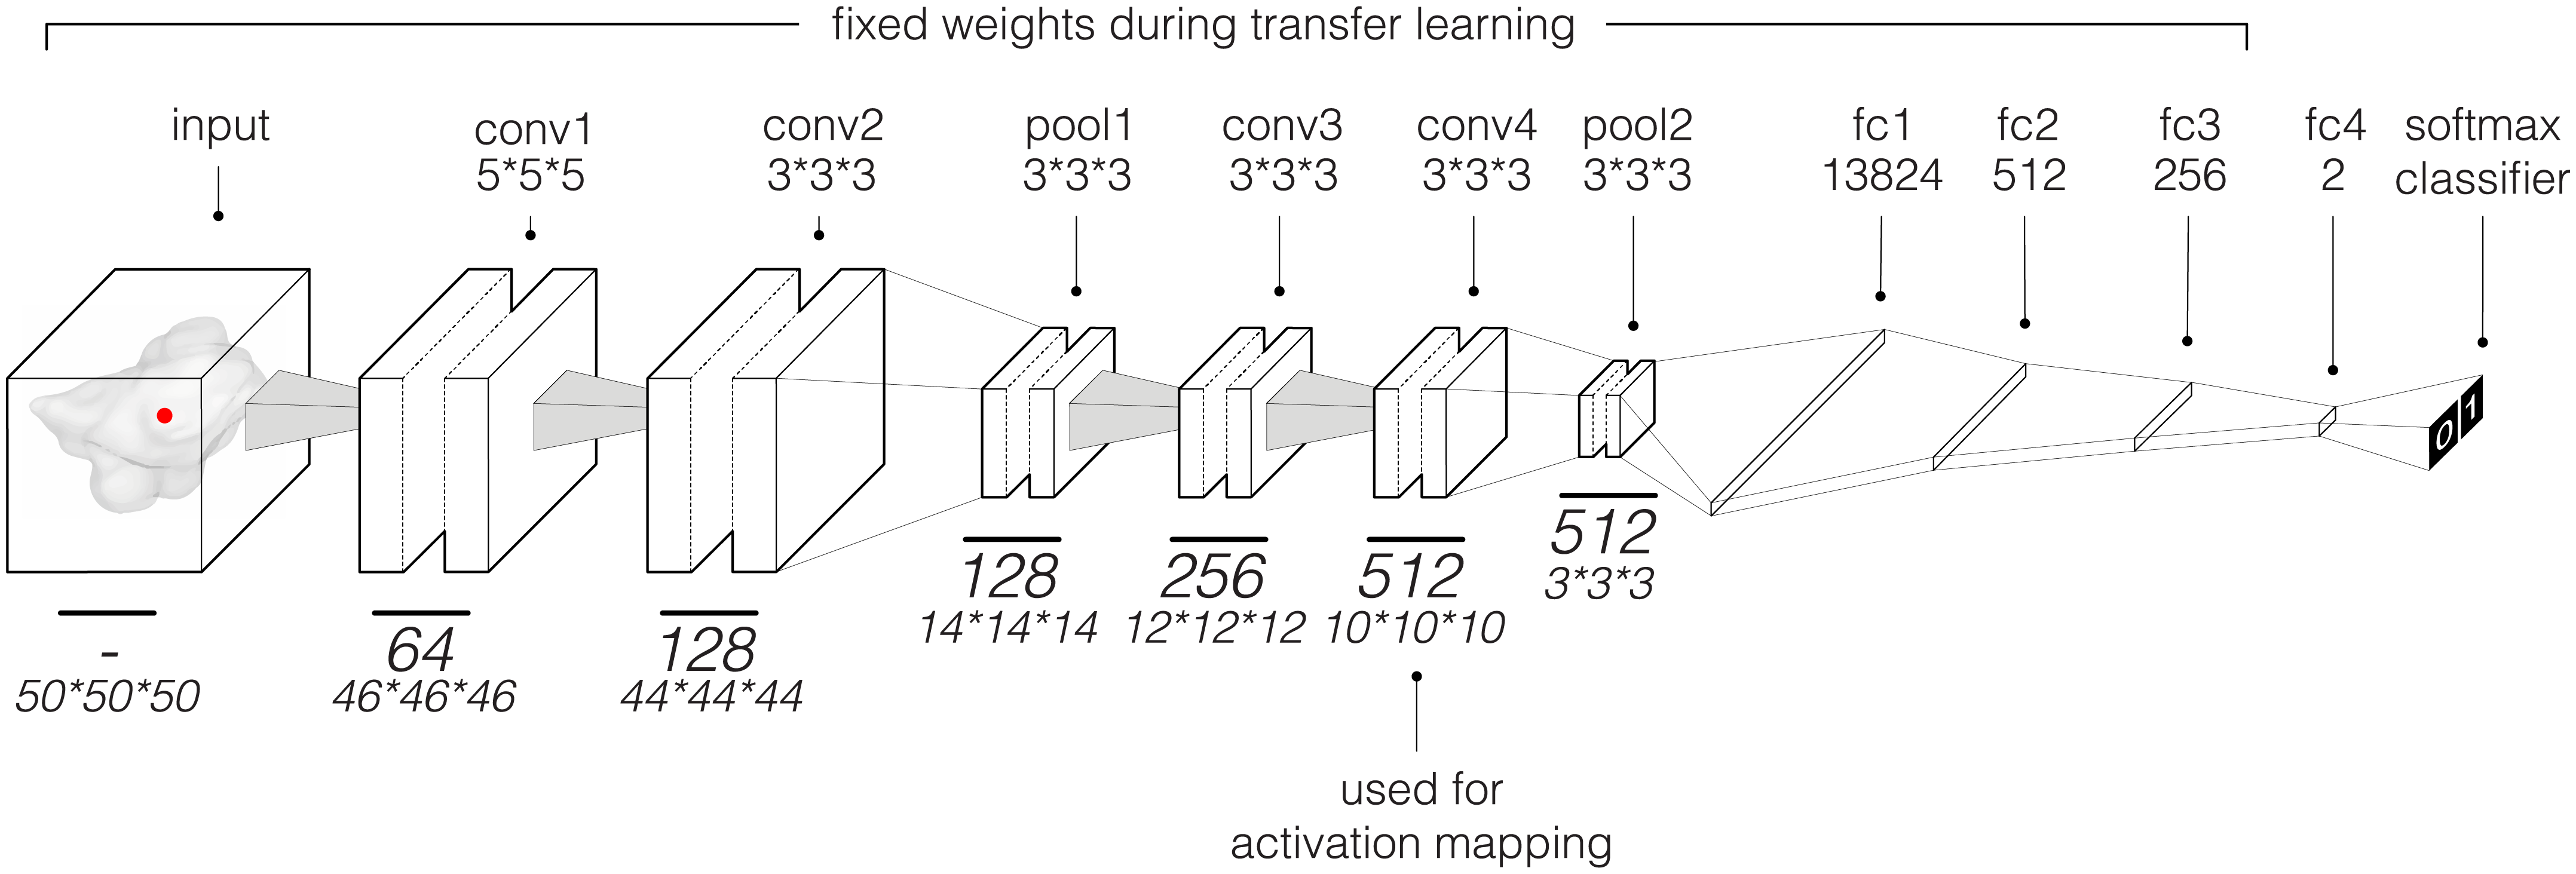

DeepPrognosis assigns a prognosis score starting from a $50 \times 50 \times 50$ voxels volume cropped around the center of mass of the lung lesion. This design choice greatly limits the impact imprecise labelling (compared to manual delineation, e.g., from the nnU-Net pipeline) can have on the analysis - and allows the model to mine information that spans beyond tumour textural features (e.g., what sorrounds the lesion). Both the aforementioned design choice and the masking experiments are described in detail in the publication.

## **Data Resampling**

During the development phase, all the CT scans were resampled to $1mm^3$ isotropic, to ensure comparability and increase model generalizability. This was achieved using linear and nearest neighbor interpolations for the image and annotations, respectively.

Therefore, before running the last step of the pipeline, we need to resample the CT scan, the GTV manual annotation (from the RTSTRUCT) and the AI-inferred segmentation mask. We can do so exploiting Plastimatch, again called from our simple python wrapper for simplicity.


In [38]:
# 1mm isotropic resampling of the segmentation mask (after largest connected component filtering)
ct_iso_nrrd_path = os.path.join(pat_dir_path_nrrd, pat + "_ct_iso.nrrd")

resample_args_pred = {"input" : ct_nrrd_path, 
                      "output" : ct_iso_nrrd_path,
                      "spacing" : "1 1 1",
                      "interpolation" : "linear"}

pypla.resample(path_to_log_file = log_file_path_nrrd, **resample_args_pred)

## ----------------------------------------

# 1mm isotropic resampling of the manual GTV delineation
rt_gtv_iso_nrrd_path = os.path.join(pat_dir_path_nrrd, pat + "_rt_gtv_iso.nrrd")

resample_args_pred = {"input" : rt_gtv_nrrd_path, 
                      "output" : rt_gtv_iso_nrrd_path,
                      "spacing" : "1 1 1",
                      "interpolation" : "nn"}

pypla.resample(path_to_log_file = log_file_path_nrrd, **resample_args_pred)

## ----------------------------------------

# 1mm isotropic resampling of the AI segmentation mask (after largest connected component filtering)
pred_gtv_iso_nrrd_path = os.path.join(pat_dir_path_nrrd, pat + "_pred_gtv_iso.nrrd")

resample_args_pred = {"input" : pred_gtv_nrrd_path, 
                      "output" : pred_gtv_iso_nrrd_path,
                      "spacing" : "1 1 1",
                      "interpolation" : "nn"}

pypla.resample(path_to_log_file = log_file_path_nrrd, **resample_args_pred)


Running 'plastimatch resample' with the specified arguments:
  --input tutorial/data/processed/nrrd/LUNG1-007/LUNG1-007_ct.nrrd
  --output tutorial/data/processed/nrrd/LUNG1-007/LUNG1-007_ct_iso.nrrd
  --spacing 1 1 1
  --interpolation linear
... Done.

Running 'plastimatch resample' with the specified arguments:
  --input tutorial/data/processed/nrrd/LUNG1-007/RTSTRUCT/GTV-1.nrrd
  --output tutorial/data/processed/nrrd/LUNG1-007/LUNG1-007_rt_gtv_iso.nrrd
  --spacing 1 1 1
  --interpolation nn
... Done.

Running 'plastimatch resample' with the specified arguments:
  --input tutorial/data/processed/nrrd/LUNG1-007/LUNG1-007_pred_gtv.nrrd
  --output tutorial/data/processed/nrrd/LUNG1-007/LUNG1-007_pred_gtv_iso.nrrd
  --spacing 1 1 1
  --interpolation nn
... Done.


We can then load the isotropically resampled volumes and compute the center of mass in the resampled space, to make sure the resampling operation did not introduce any problem.

In [39]:
ct_nrrd_iso = sitk.GetArrayFromImage(sitk.ReadImage(ct_iso_nrrd_path))

pred_nrrd_gtv_iso = sitk.GetArrayFromImage(sitk.ReadImage(pred_gtv_iso_nrrd_path))
rt_nrrd_gtv_iso = sitk.GetArrayFromImage(sitk.ReadImage(rt_gtv_iso_nrrd_path))

In [40]:
com_manual_iso = np.array(getCenterOfMassIndexValue(rt_nrrd_gtv_iso))
com_manual_iso_int = np.ceil(com_manual_iso).astype(dtype = np.uint16)

com_lcc_iso = np.array(getCenterOfMassIndexValue(pred_nrrd_gtv_iso))
com_lcc_iso_int = np.ceil(com_lcc_iso).astype(dtype = np.uint16)

print("Center of Mass   (LCC segmentation) \t:", com_lcc_iso_int)
print("Center of Mass   (manual segmentation) \t:", com_manual_iso_int)

Center of Mass   (LCC segmentation) 	: [168 211 194]
Center of Mass   (manual segmentation) 	: [165 212 194]


## **Data Processing**

Finally, we can load the pre-trained weights for DeepPrognosis and run the last part of the pipeline.

In [41]:
%%capture
model_base_path = "tutorial/models"

arch_json_path = os.path.join(model_base_path, "dp_arch.json")
weights_path = os.path.join(model_base_path, "dp_weights.h5")

"""
 N.B. any warnings are due to the fact that the model was developed for
 Keras 1, and the config file has been converted in a Keras-2-compatible file

 Nonetheless, Keras 2 uses different naming conventions/def.s, so in order to
 get rid of the warnings one should change all the layers def.s in the JSON file
"""

# load the model architecture from the config file, then load the model weights 
with open(arch_json_path, 'r') as json_file:
    model_json = json.load(json_file)  

model = keras.models.model_from_config(model_json)
model.load_weights(weights_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


The intensity values of the $50 \times 50 \times 50$ subvolume input to the DeepPrognosis model needs to be normalised from the 12 bits range of the DICOM CT integer intensities (from $-1024$ to $3071$) to $0$ and $1$ (floating point). We can do so by defining a simple function as follows:

In [42]:
# normalise the values of the volume between new_min_val and new_max_val
def normaliseVolume(input_volume, new_min_val, new_max_val, old_min_val = None, old_max_val = None):

  """
  Normalise a numpy volume intensity in a range between two given values
  
  @params:
    input_volume - required : numpy volume to rescale (intensity-wise) in the new range.
    new_min_val  - required : the lower bound of the new intensity range.
    new_max_val  - required : the upper bound of the new intensity range.
    old_min_val  - optional : the lower bound of the old intensity range. Defaults to input_volume's np.min()
    old_max_val  - optional : the lower bound of the old intensity range. Defaults to input_volume's np.max()
    
  """
  
  # make sure the input volume is treated as a float volume
  input_volume = input_volume.astype(dtype = np.float16)

  # if no old_min_val and/or old_max_val are specified, default to the np.min() and np.max() of input_volume
  
  curr_min = np.min(input_volume) if old_min_val == None else old_min_val
  curr_max = np.max(input_volume) if old_max_val == None else old_max_val


  # normalise the values of each voxel between zero and one
  zero_to_one_norm = (input_volume - curr_min)/(curr_max - curr_min)

  # normalise between new_min_val and new_max_val
  return (new_max_val - new_min_val)*zero_to_one_norm + new_min_val

Before feeding the $50 \times 50 \times 50$ subvolumes enclosing the lung lesion - one cropped around the center of mass of the manual delineation, and the other around that of the AI segmentation - to the DeepPrognosis model, we can inspect them so try to gain insight on what features the AI model will be extracting to assign a survival score. Let's start by computing the crop:

In [43]:
# 1mm isotropic 50x50x50 crop using the manual delineation
ct_nrrd_iso_crop_manual = ct_nrrd_iso[com_manual_iso_int[0]-25 : com_manual_iso_int[0]+25,
                                      com_manual_iso_int[1]-25 : com_manual_iso_int[1]+25,
                                      com_manual_iso_int[2]-25 : com_manual_iso_int[2]+25]

# 1mm isotropic 50x50x50 crop using the AI segmentation mask
ct_nrrd_iso_crop_ai = ct_nrrd_iso[com_lcc_iso_int[0]-25 : com_lcc_iso_int[0]+25,
                                  com_lcc_iso_int[1]-25 : com_lcc_iso_int[1]+25,
                                  com_lcc_iso_int[2]-25 : com_lcc_iso_int[2]+25]

To scroll between the subvolume (axial) slices, use the slider above the following cell.

In [44]:
_ = viz_utils.AxialSliceComparison(ct_volume_left = ct_nrrd_iso_crop_ai,
                                   ct_volume_right = ct_nrrd_iso_crop_manual,
                                   dpi = 150,
                                   figsize = (8, 8))

interactive(children=(Output(),), _dom_classes=('widget-interact',))

As the last step, let's feed the cropped and normalised subvolumes into to the DeepPrognosis model.

In [45]:
input_volume = normaliseVolume(input_volume = ct_nrrd_iso_crop_manual,
                               new_min_val = 0., new_max_val = 1.,
                               old_min_val = -1024, old_max_val = 3071)

input_volume = np.expand_dims(input_volume, axis = 0)
input_volume = np.expand_dims(input_volume, axis = -1)
    
# 2 yrs survival score is logit 1; N.B. - this is not the survival probability!
# The model stratifies patients well, but does not provide that kind of information
y_pred_raw = model.predict(input_volume)

pat_dict = dict()
pat_dict["PatientID"] = pat
pat_dict["path_to_nrrd"] = ct_nrrd_path
pat_dict["surv_score_manual_seg"] = y_pred_raw[0, 1]

## ----------------------------------------

input_volume = normaliseVolume(input_volume = ct_nrrd_iso_crop_ai,
                               new_min_val = 0., new_max_val = 1.,
                               old_min_val = -1024, old_max_val = 3071)

input_volume = np.expand_dims(input_volume, axis = 0)
input_volume = np.expand_dims(input_volume, axis = -1)
    
# 2 yrs survival score is logit 1; N.B. - this is not the survival probability!
# The model stratifies patients well, but does not provide that kind of information
y_pred_raw = model.predict(input_volume)

pat_dict["surv_score_AI_seg"] = y_pred_raw[0, 1]

## **Interpreting the Pipeline Results**

DeepPrognosis outputs a score in the form of a $1 \times 2$ vector, storing the probabilities for the patient to be alive or deceased after two years, respectively. With the next cell, we can visualise side by side the score assigned by the DeepPrognosis model when processing the $50 \times 50 \times 50$ volume cropped around the center of mass of the AI segmentation mask computed in the first part of this notebook (`surv_score_AI_seg`), and the same score computed starting from the subvolume cropped around the center of mass of the manual delineation (`surv_score_seg_seg`). This provides us with an additional downstream way to evaluate the AI segmentation.

In [46]:
res_df = pd.DataFrame()
processed_pat_list = list()
    
res_df = res_df.append(pat_dict, ignore_index = True)

res_df

PatientID  ... surv_score_manual_seg
0  LUNG1-007  ...              0.045547

[1 rows x 4 columns]

Regarding the DeepPrognosis score, to conduct a thorough evaluation one would need to compute metrics like ROC AUC on the whole external and intependent test set - or conducting survival analyses, as seen in the original paper.

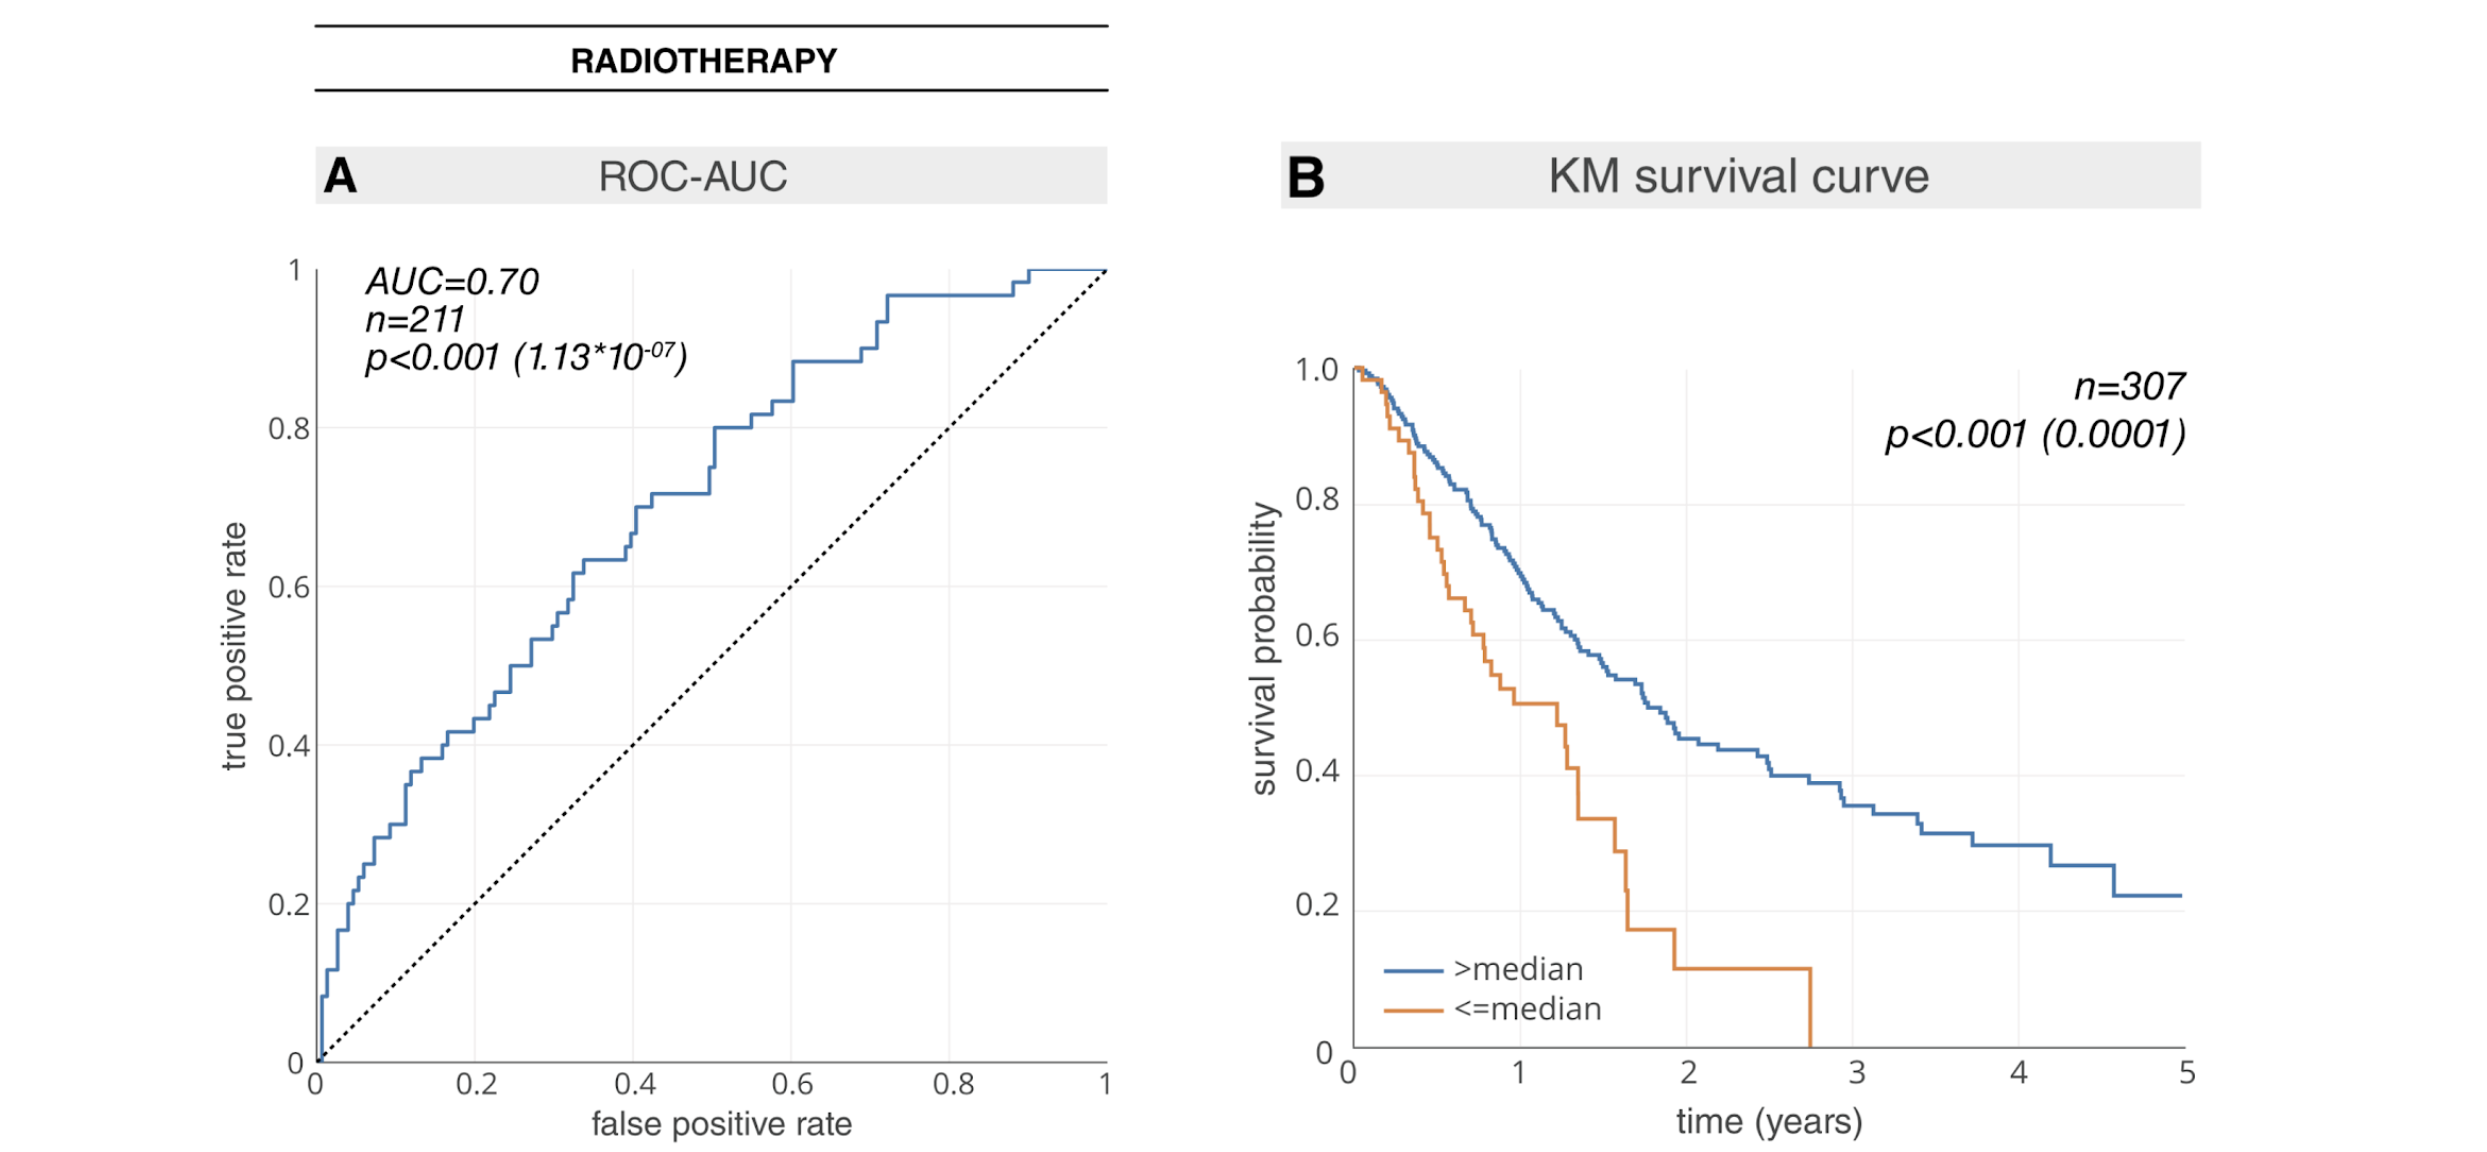

Unfortunately, running this analysis on Google Colab (and in the context of this tutorial!) is not feasible due to time constraints.

If you are interested in such analysis (or conducting a similar analysis yourself, on one of the datasets the IDC portal hosts), make sure to check out the Google VMs and the codebases IDC provides the user with.